# Introducción al Downscaling Climático

El **downscaling** o escalamiento climático es una técnica que permite traducir datos de modelos climáticos o reanálisis, de baja resolución espacial, a escalas locales o puntuales, con mayor detalle. Este proceso es esencial para aplicaciones hidrológicas, agrícolas y de gestión de riesgos climáticos.

## Métodos comunes de downscaling:

1. **Tasa Altitudinal (Lapse Rate Correction)**  
   Ajusta las temperaturas simuladas en función de la diferencia de altitud entre el punto de reanálisis y la estación meteorológica, utilizando una tasa estándar (por ejemplo, -6.5 °C/km).  
   - Simple, pero útil en regiones montañosas.
   - No considera otros factores meteorológicos.

2. **Regresión Lineal**  
   Utiliza una relación estadística entre variables del reanálisis (predictoras) y datos observados (respuesta), generalmente con una única variable independiente.  
   - Método interpretable.
   - Supone una relación lineal fija entre variables.

3. **XGBoost (Extreme Gradient Boosting)**  
   Técnica de **machine learning** basada en árboles de decisión optimizados por gradiente. Permite capturar relaciones no lineales y multivariadas entre datos de reanálisis y observaciones locales.  
   - Alto rendimiento predictivo.
   - Requiere más datos y calibración cuidadosa.

Estas técnicas pueden aplicarse a variables como temperatura, precipitación, viento o radiación, utilizando datos como los del reanálisis **ERA5** y observaciones de estaciones meteorológicas.


## Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xarray as xr
from sklearn.linear_model import LinearRegression
import math
from scipy.stats import pearsonr
# Importa la función de densidad de probabilidad kernel gaussiana de scipy
from scipy.stats import gaussian_kde


## Leer datos

### Datos ERA5

In [2]:
path_dir = '../data/ERA5_AG/'

ds1 = xr.open_dataset(f'{path_dir}ERA5_{2016}_ins.nc')
ds2 = xr.open_dataset(f'{path_dir}ERA5_{2016}_accum.nc')
ds3 = xr.open_dataset(f'{path_dir}ERA5_{2016}_rrr.nc')

In [3]:
ds3_3h = ds3.resample(valid_time='3h').sum()
ds3_3h

<xarray.Dataset> Size: 35kB
Dimensions:     (valid_time: 2928, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B 0
  * latitude    (latitude) float64 8B -8.98
  * longitude   (longitude) float64 8B -77.65
  * valid_time  (valid_time) datetime64[ns] 23kB 2016-01-01 ... 2016-12-31T21...
Data variables:
    tp          (valid_time, latitude, longitude) float32 12kB 0.002401 ... 0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-29T04:45 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds = xr.merge([ds1, ds2, ds3_3h])
ds

<xarray.Dataset> Size: 176kB
Dimensions:     (valid_time: 2928, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 23kB 2016-01-01 ... 2016-12-31T21...
  * latitude    (latitude) float64 8B -8.98
  * longitude   (longitude) float64 8B -77.65
    expver      (valid_time) <U4 47kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    u10         (valid_time, latitude, longitude) float32 12kB ...
    v10         (valid_time, latitude, longitude) float32 12kB ...
    d2m         (valid_time, latitude, longitude) float32 12kB ...
    t2m         (valid_time, latitude, longitude) float32 12kB ...
    sp          (valid_time, latitude, longitude) float32 12kB ...
    z           (valid_time, latitude, longitude) float32 12kB ...
    ssrd        (valid_time, latitude, longitude) float32 12kB ...
    strd        (valid_time, latitude, longitude) float32 12kB ...
    tp          (valid_time, latitude, longitude) float32 12kB 0.002401 ... 0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-29T13:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
years = np.arange(2016, 2019, 1)
print(years)

[2016 2017 2018]


In [6]:
ds_list = []
for year in years:
    ds1 = xr.open_dataset(f'{path_dir}ERA5_{year}_ins.nc')
    ds2 = xr.open_dataset(f'{path_dir}ERA5_{year}_accum.nc')
    ds3 = xr.open_dataset(f'{path_dir}ERA5_{year}_rrr.nc').resample(valid_time='3h').sum()
    ds_list.append(xr.merge([ds1, ds2, ds3]))


In [7]:
ds_list

[<xarray.Dataset> Size: 176kB
 Dimensions:     (valid_time: 2928, latitude: 1, longitude: 1)
 Coordinates:
     number      int64 8B 0
   * valid_time  (valid_time) datetime64[ns] 23kB 2016-01-01 ... 2016-12-31T21...
   * latitude    (latitude) float64 8B -8.98
   * longitude   (longitude) float64 8B -77.65
     expver      (valid_time) <U4 47kB '0001' '0001' '0001' ... '0001' '0001'
 Data variables:
     u10         (valid_time, latitude, longitude) float32 12kB ...
     v10         (valid_time, latitude, longitude) float32 12kB ...
     d2m         (valid_time, latitude, longitude) float32 12kB ...
     t2m         (valid_time, latitude, longitude) float32 12kB ...
     sp          (valid_time, latitude, longitude) float32 12kB ...
     z           (valid_time, latitude, longitude) float32 12kB ...
     ssrd        (valid_time, latitude, longitude) float32 12kB ...
     strd        (valid_time, latitude, longitude) float32 12kB ...
     tp          (valid_time, latitude, longitude) f

In [8]:
ds = xr.merge(ds_list)
ds

<xarray.Dataset> Size: 456kB
Dimensions:     (valid_time: 8768, latitude: 1, longitude: 1)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2016-01-01 ... 2018-12-31T21...
  * latitude    (latitude) float64 8B -8.98
  * longitude   (longitude) float64 8B -77.65
    number      int64 8B 0
    expver      (valid_time) object 70kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    u10         (valid_time, latitude, longitude) float32 35kB 0.5303 ... 0.245
    v10         (valid_time, latitude, longitude) float32 35kB -0.1953 ... -1...
    d2m         (valid_time, latitude, longitude) float32 35kB 280.3 ... 280.4
    t2m         (valid_time, latitude, longitude) float32 35kB 282.0 ... 283.3
    sp          (valid_time, latitude, longitude) float32 35kB 6.413e+04 ... ...
    z           (valid_time, latitude, longitude) float32 35kB 3.802e+04 ... ...
    ssrd        (valid_time, latitude, longitude) float32 35kB 4.862e+04 ... ...
    strd        (valid_time, latitude, longitude) float32 35kB 1.138e+06 ... ...
    tp          (valid_time, latitude, longitude) float32 35kB 0.002401 ... 0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-29T13:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [116]:
df_era5 = ds.isel(latitude=0, longitude=0).to_dataframe().drop(columns=['number', 'latitude', 'longitude', 'expver'])
df_era5

u10       v10         d2m         t2m            sp  \
valid_time                                                                      
2016-01-01 00:00:00  0.530328 -0.195289  280.261719  282.010498  64132.816406   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248  281.098633  64277.039062   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797  279.477295  64156.378906   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105  278.936035  64053.773438   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789  280.592285  64139.488281   
...                       ...       ...         ...         ...           ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031  276.312012  63932.328125   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926  278.979980  64062.070312   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  283.444336  64101.128906   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  285.765869  63981.886719   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  283.261719  63838.386719   

                                z          ssrd         strd        tp  
valid_time                                                              
2016-01-01 00:00:00  38015.128906  4.862297e+04  1137510.000  0.002401  
2016-01-01 03:00:00  38015.128906  0.000000e+00  1183276.000  0.001439  
2016-01-01 06:00:00  38015.128906  0.000000e+00  1148512.000  0.000410  
2016-01-01 09:00:00  38015.128906  0.000000e+00  1037555.375  0.000171  
2016-01-01 12:00:00  38015.128906  2.686684e+05  1115361.000  0.000173  
...                           ...           ...          ...       ...  
2018-12-31 09:00:00  38015.128906  0.000000e+00  1090498.000  0.000075  
2018-12-31 12:00:00  38015.128906  1.924180e+05  1106514.000  0.000246  
2018-12-31 15:00:00  38015.128906  2.563318e+06  1065091.000  0.000557  
2018-12-31 18:00:00  38015.128906  3.199770e+06  1147421.000  0.001128  
2018-12-31 21:00:00  38015.128906  1.665148e+06  1201442.000  0.001887  

[8768 rows x 9 columns]

In [117]:
## Velocidad del viento
U10 = np.sqrt(df_era5['u10']**2 + df_era5['v10']**2)
df_era5['ws2'] = U10 * (np.log(2 / (2.12 * 1000)) / np.log(10 / (2.12 * 1000)))
df_era5

u10       v10         d2m         t2m            sp  \
valid_time                                                                      
2016-01-01 00:00:00  0.530328 -0.195289  280.261719  282.010498  64132.816406   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248  281.098633  64277.039062   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797  279.477295  64156.378906   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105  278.936035  64053.773438   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789  280.592285  64139.488281   
...                       ...       ...         ...         ...           ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031  276.312012  63932.328125   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926  278.979980  64062.070312   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  283.444336  64101.128906   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  285.765869  63981.886719   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  283.261719  63838.386719   

                                z          ssrd         strd        tp  \
valid_time                                                               
2016-01-01 00:00:00  38015.128906  4.862297e+04  1137510.000  0.002401   
2016-01-01 03:00:00  38015.128906  0.000000e+00  1183276.000  0.001439   
2016-01-01 06:00:00  38015.128906  0.000000e+00  1148512.000  0.000410   
2016-01-01 09:00:00  38015.128906  0.000000e+00  1037555.375  0.000171   
2016-01-01 12:00:00  38015.128906  2.686684e+05  1115361.000  0.000173   
...                           ...           ...          ...       ...   
2018-12-31 09:00:00  38015.128906  0.000000e+00  1090498.000  0.000075   
2018-12-31 12:00:00  38015.128906  1.924180e+05  1106514.000  0.000246   
2018-12-31 15:00:00  38015.128906  2.563318e+06  1065091.000  0.000557   
2018-12-31 18:00:00  38015.128906  3.199770e+06  1147421.000  0.001128   
2018-12-31 21:00:00  38015.128906  1.665148e+06  1201442.000  0.001887   

                          ws2  
valid_time                     
2016-01-01 00:00:00  0.734944  
2016-01-01 03:00:00  0.555618  
2016-01-01 06:00:00  0.398775  
2016-01-01 09:00:00  0.207715  
2016-01-01 12:00:00  0.480782  
...                       ...  
2018-12-31 09:00:00  0.968212  
2018-12-31 12:00:00  1.614325  
2018-12-31 15:00:00  1.206408  
2018-12-31 18:00:00  1.025051  
2018-12-31 21:00:00  1.462325  

[8768 rows x 10 columns]

In [118]:
## Humedad relativa

# Constants for humidity calculation
T0 = 273.16
a1 = 611.21
a3 = 17.502
a4 = 32.19
R_dry = 287.0597
R_vap = 461.5250


T_e_sat = a1 * np.exp(a3 * ((df_era5['t2m'] - T0) / (df_era5['t2m'] - a4)))
Td_e_sat = a1 * np.exp(a3 * ((df_era5['d2m'] - T0) / (df_era5['d2m'] - a4)))
df_era5['rh']  = 100 * Td_e_sat / T_e_sat
df_era5['rh'] = df_era5['rh'].clip(lower=0, upper=100)
df_era5

u10       v10         d2m         t2m            sp  \
valid_time                                                                      
2016-01-01 00:00:00  0.530328 -0.195289  280.261719  282.010498  64132.816406   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248  281.098633  64277.039062   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797  279.477295  64156.378906   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105  278.936035  64053.773438   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789  280.592285  64139.488281   
...                       ...       ...         ...         ...           ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031  276.312012  63932.328125   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926  278.979980  64062.070312   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  283.444336  64101.128906   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  285.765869  63981.886719   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  283.261719  63838.386719   

                                z          ssrd         strd        tp  \
valid_time                                                               
2016-01-01 00:00:00  38015.128906  4.862297e+04  1137510.000  0.002401   
2016-01-01 03:00:00  38015.128906  0.000000e+00  1183276.000  0.001439   
2016-01-01 06:00:00  38015.128906  0.000000e+00  1148512.000  0.000410   
2016-01-01 09:00:00  38015.128906  0.000000e+00  1037555.375  0.000171   
2016-01-01 12:00:00  38015.128906  2.686684e+05  1115361.000  0.000173   
...                           ...           ...          ...       ...   
2018-12-31 09:00:00  38015.128906  0.000000e+00  1090498.000  0.000075   
2018-12-31 12:00:00  38015.128906  1.924180e+05  1106514.000  0.000246   
2018-12-31 15:00:00  38015.128906  2.563318e+06  1065091.000  0.000557   
2018-12-31 18:00:00  38015.128906  3.199770e+06  1147421.000  0.001128   
2018-12-31 21:00:00  38015.128906  1.665148e+06  1201442.000  0.001887   

                          ws2         rh  
valid_time                                
2016-01-01 00:00:00  0.734944  88.779968  
2016-01-01 03:00:00  0.555618  91.838936  
2016-01-01 06:00:00  0.398775  94.054993  
2016-01-01 09:00:00  0.207715  93.262016  
2016-01-01 12:00:00  0.480782  82.930542  
...                       ...        ...  
2018-12-31 09:00:00  0.968212  95.798843  
2018-12-31 12:00:00  1.614325  86.473648  
2018-12-31 15:00:00  1.206408  66.027306  
2018-12-31 18:00:00  1.025051  72.671013  
2018-12-31 21:00:00  1.462325  82.226036  

[8768 rows x 11 columns]

In [119]:
g = 9.81 ## m/s**2
df_era5['t2m'] = df_era5['t2m'] - 272.15
df_era5['sp'] = df_era5['sp'] / 100
df_era5['z'] = df_era5['z'] / g
df_era5['ssrd'] = df_era5['ssrd'] / 3600 # J a W
df_era5['strd'] = df_era5['strd'] / 3600 # J a W
df_era5['tp'] = df_era5['tp'] * 1000 # m a mm
df_era5


u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  
valid_time                      
2016-01-01 00:00:00  88.779968  
2016-01-01 03:00:00  91.838936  
2016-01-01 06:00:00  94.054993  
2016-01-01 09:00:00  93.262016  
2016-01-01 12:00:00  82.930542  
...                        ...  
2018-12-31 09:00:00  95.798843  
2018-12-31 12:00:00  86.473648  
2018-12-31 15:00:00  66.027306  
2018-12-31 18:00:00  72.671013  
2018-12-31 21:00:00  82.226036  

[8768 rows x 11 columns]

### Datos AWS

In [127]:
filename = '../data/arteson_2016_2018_1h.csv'
df_aws   =  pd.read_csv(filename, sep='\t')
df_aws.TIMESTAMP = pd.to_datetime(df_aws.TIMESTAMP)
df_aws.set_index('TIMESTAMP', inplace=True)
vars_aws = df_aws.columns

df_aws['data_hora_LT'] = df_aws.index.tz_localize('America/Lima')
df_aws['data_hora_utc'] = df_aws['data_hora_LT'].dt.tz_convert('UTC')
# Remover o timezone (ex: -05:00)
df_aws['TIMESTAMP'] = df_aws['data_hora_utc'].dt.tz_localize(None)
df_aws.set_index('TIMESTAMP', inplace=True)
df_aws = df_aws[vars_aws]
df_aws['SWin_Avg'] = df_aws['SWin_Avg'].clip(lower=0, upper=1400)
df_aws

SWin_Avg    Ta_Avg     Rh_Avg     WiSp     WiDi  \
TIMESTAMP                                                              
2016-07-01 05:00:00       0.0  0.591361  34.213620  11.6550   65.335   
2016-07-01 06:00:00       0.0  0.760301  30.400370   9.3000   70.685   
2016-07-01 07:00:00       0.0  0.813334  27.793420  11.7300   69.305   
2016-07-01 08:00:00       0.0  0.409199  30.604810  11.8500   67.440   
2016-07-01 09:00:00       0.0  0.003931  36.164870  12.2600   67.555   
...                       ...       ...        ...      ...      ...   
2018-09-01 00:00:00       0.0  2.687170  59.142930   5.5160   53.230   
2018-09-01 01:00:00       0.0  1.667032  66.131200   1.9225   48.375   
2018-09-01 02:00:00       0.0  1.204681  67.336475   1.2865   85.075   
2018-09-01 03:00:00       0.0  0.902623  67.107090   1.1550  136.805   
2018-09-01 04:00:00       0.0  1.471030  59.285550   4.1270   45.660   

                     pressure  precip_Tot  
TIMESTAMP                                  
2016-07-01 05:00:00    747.75        0.03  
2016-07-01 06:00:00    747.30        0.03  
2016-07-01 07:00:00    744.50        0.07  
2016-07-01 08:00:00    744.85        0.00  
2016-07-01 09:00:00    745.45        0.06  
...                       ...         ...  
2018-09-01 00:00:00    745.00        0.00  
2018-09-01 01:00:00    746.05        0.00  
2018-09-01 02:00:00    746.55        0.00  
2018-09-01 03:00:00    746.80        0.00  
2018-09-01 04:00:00    746.45        0.00  

[19008 rows x 7 columns]

In [128]:
agg_dict = {
    'SWin_Avg': 'mean',
    'Ta_Avg': 'mean',
    'Rh_Avg': 'mean',
    'WiSp': 'mean',
    'pressure': 'mean',
    'precip_Tot': 'sum'
}

df_aws = df_aws.resample('3h').agg(agg_dict)
df_aws['pressure'] = df_aws['pressure'] - 172 ## 
df_aws

SWin_Avg    Ta_Avg     Rh_Avg       WiSp    pressure  \
TIMESTAMP                                                                      
2016-07-01 03:00:00     0.000000  0.591361  34.213620  11.655000  575.750000   
2016-07-01 06:00:00     0.000000  0.660945  29.599533  10.960000  573.550000   
2016-07-01 09:00:00     0.000000  0.192607  34.025007  12.420000  573.466667   
2016-07-01 12:00:00   274.036442  0.995564  25.953613  11.261667  575.933333   
2016-07-01 15:00:00   927.716983  2.789046  26.091212  12.281667  576.400000   
...                          ...       ...        ...        ...         ...   
2018-08-31 15:00:00  1078.870833  3.526608  37.716142   9.128833  574.900000   
2018-08-31 18:00:00   982.642233  4.969871  36.616743   9.956667  572.400000   
2018-08-31 21:00:00   251.433163  4.585310  43.965165   8.264500  571.700000   
2018-09-01 00:00:00     0.000000  1.852961  64.203535   2.908333  573.866667   
2018-09-01 03:00:00     0.000000  1.186826  63.196320   2.641000  574.625000   

                     precip_Tot  
TIMESTAMP                        
2016-07-01 03:00:00        0.03  
2016-07-01 06:00:00        0.10  
2016-07-01 09:00:00        0.15  
2016-07-01 12:00:00        0.09  
2016-07-01 15:00:00        0.13  
...                         ...  
2018-08-31 15:00:00        0.06  
2018-08-31 18:00:00        0.07  
2018-08-31 21:00:00        0.00  
2018-09-01 00:00:00        0.00  
2018-09-01 03:00:00        0.00  

[6337 rows x 6 columns]

## Escalamiento ERA5 para AWS T2

In [129]:
# Altura de la estación y del punto ERA5
alt_era5 = df_era5['z'].values[0]  # m
alt_estacion = 4817  # m
lapse_rate = -0.0065  # °C/m

print(alt_era5, alt_estacion)

3875.1404 4817


In [130]:
# Juntar ambos df
df_era5_aws = pd.merge(df_era5, df_aws, left_index=True, right_index=True, how='left')
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  
valid_time                       
2016-01-01 00:00:00         NaN  
2016-01-01 03:00:00         NaN  
2016-01-01 06:00:00         NaN  
2016-01-01 09:00:00         NaN  
2016-01-01 12:00:00         NaN  
...                         ...  
2018-12-31 09:00:00         NaN  
2018-12-31 12:00:00         NaN  
2018-12-31 15:00:00         NaN  
2018-12-31 18:00:00         NaN  
2018-12-31 21:00:00         NaN  

[8768 rows x 17 columns]

In [131]:
df_era5_aws.columns

Index(['u10', 'v10', 'd2m', 't2m', 'sp', 'z', 'ssrd', 'strd', 'tp', 'ws2',
       'rh', 'SWin_Avg', 'Ta_Avg', 'Rh_Avg', 'WiSp', 'pressure', 'precip_Tot'],
      dtype='object')

### Ecalamiento por Tasa Altitudinal

In [17]:
df_era5_aws['t2m_corr_lp'] = df_era5_aws['t2m'] + lapse_rate * (alt_estacion - alt_era5)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  t2m_corr_lp  
valid_time                                    
2016-01-01 00:00:00         NaN     3.738417  
2016-01-01 03:00:00         NaN     2.826551  
2016-01-01 06:00:00         NaN     1.205214  
2016-01-01 09:00:00         NaN     0.663954  
2016-01-01 12:00:00         NaN     2.320204  
...                         ...          ...  
2018-12-31 09:00:00         NaN    -1.960070  
2018-12-31 12:00:00         NaN     0.707899  
2018-12-31 15:00:00         NaN     5.172255  
2018-12-31 18:00:00         NaN     7.493788  
2018-12-31 21:00:00         NaN     4.989637  

[8768 rows x 18 columns]

### Escalamiento por regresion lineal

In [132]:
df_era5_aws['ele_aws'] = alt_estacion

In [133]:
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  ele_aws  
valid_time                                
2016-01-01 00:00:00         NaN     4817  
2016-01-01 03:00:00         NaN     4817  
2016-01-01 06:00:00         NaN     4817  
2016-01-01 09:00:00         NaN     4817  
2016-01-01 12:00:00         NaN     4817  
...                         ...      ...  
2018-12-31 09:00:00         NaN     4817  
2018-12-31 12:00:00         NaN     4817  
2018-12-31 15:00:00         NaN     4817  
2018-12-31 18:00:00         NaN     4817  
2018-12-31 21:00:00         NaN     4817  

[8768 rows x 18 columns]

In [20]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'u10' y 'v10': componentes zonal y meridional del viento a 10 m (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Ta_Avg': temperatura media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['t2m', 'ssrd', 'u10', 'v10', 'z', 'ele_aws', 'Ta_Avg']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['Ta_Avg']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [21]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.2f} °C")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 1.14 °C
[Regresión Lineal] R²: 0.65


In [22]:
X_full = df_era5_aws[vars].drop(columns=['Ta_Avg'])
df_era5_aws['t2m_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  t2m_corr_lp  ele_aws  t2m_corr_lineal  
valid_time                                                              
2016-01-01 00:00:00         NaN     3.738417     4817         1.659148  
2016-01-01 03:00:00         NaN     2.826551     4817         1.495377  
2016-01-01 06:00:00         NaN     1.205214     4817         1.169642  
2016-01-01 09:00:00         NaN     0.663954     4817         1.039193  
2016-01-01 12:00:00         NaN     2.320204     4817         1.621121  
...                         ...          ...      ...              ...  
2018-12-31 09:00:00         NaN    -1.960070     4817         0.439488  
2018-12-31 12:00:00         NaN     0.707899     4817         1.191571  
2018-12-31 15:00:00         NaN     5.172255     4817         3.918464  
2018-12-31 18:00:00         NaN     7.493788     4817         4.849415  
2018-12-31 21:00:00         NaN     4.989637     4817         2.996085  

[8768 rows x 20 columns]

### Escalamiento con Machine Learing

In [23]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.2f} °C")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 1.03 °C
[XGBoost] R²: 0.71


In [24]:
X_full = df_era5_aws[vars].drop(columns=['Ta_Avg'])
df_era5_aws['t2m_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time           ...                                             
2016-01-01 00:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  ...       NaN     NaN     NaN   NaN       NaN   
...                  ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  ...       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  ...       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  t2m_corr_lp  ele_aws  t2m_corr_lineal  \
valid_time                                                               
2016-01-01 00:00:00         NaN     3.738417     4817         1.659148   
2016-01-01 03:00:00         NaN     2.826551     4817         1.495377   
2016-01-01 06:00:00         NaN     1.205214     4817         1.169642   
2016-01-01 09:00:00         NaN     0.663954     4817         1.039193   
2016-01-01 12:00:00         NaN     2.320204     4817         1.621121   
...                         ...          ...      ...              ...   
2018-12-31 09:00:00         NaN    -1.960070     4817         0.439488   
2018-12-31 12:00:00         NaN     0.707899     4817         1.191571   
2018-12-31 15:00:00         NaN     5.172255     4817         3.918464   
2018-12-31 18:00:00         NaN     7.493788     4817         4.849415   
2018-12-31 21:00:00         NaN     4.989637     4817         2.996085   

                     t2m_corr_xgb  
valid_time                         
2016-01-01 00:00:00     

## Visualización

In [25]:
vars_t2 = ['Ta_Avg', 't2m', 't2m_corr_lp', 't2m_corr_lineal', 't2m_corr_xgb']
df_t2 = df_era5_aws[vars_t2]
df_t2

Ta_Avg        t2m  t2m_corr_lp  t2m_corr_lineal  \
valid_time                                                             
2016-01-01 00:00:00     NaN   9.860504     3.738417         1.659148   
2016-01-01 03:00:00     NaN   8.948639     2.826551         1.495377   
2016-01-01 06:00:00     NaN   7.327301     1.205214         1.169642   
2016-01-01 09:00:00     NaN   6.786041     0.663954         1.039193   
2016-01-01 12:00:00     NaN   8.442291     2.320204         1.621121   
...                     ...        ...          ...              ...   
2018-12-31 09:00:00     NaN   4.162018    -1.960070         0.439488   
2018-12-31 12:00:00     NaN   6.829987     0.707899         1.191571   
2018-12-31 15:00:00     NaN  11.294342     5.172255         3.918464   
2018-12-31 18:00:00     NaN  13.615875     7.493788         4.849415   
2018-12-31 21:00:00     NaN  11.111725     4.989637         2.996085   

                     t2m_corr_xgb  
valid_time                         
2016-01-01 00:00:00      1.632994  
2016-01-01 03:00:00      1.737234  
2016-01-01 06:00:00      1.154999  
2016-01-01 09:00:00      0.864530  
2016-01-01 12:00:00      1.985084  
...                           ...  
2018-12-31 09:00:00      0.376000  
2018-12-31 12:00:00      1.185451  
2018-12-31 15:00:00      3.597916  
2018-12-31 18:00:00      5.152278  
2018-12-31 21:00:00      3.185483  

[8768 rows x 5 columns]

In [26]:

def plot_series(df, n_toplot=10**10,):


    # Crea una copia del DataFrame original y elimina filas con valores faltantes
    df_nan = df.copy().dropna()

    # Renombra las columnas a 'OBS' (observado) y 'SIM' (simulado)
    df_nan.columns = ['OBS', 'SIM']

    # Extrae los valores como arrays numpy
    y1 = df_nan['OBS'].values  # serie observada
    y2 = df_nan['SIM'].values  # serie simulada

    # Crea un arreglo de índices de la misma longitud que las series
    idxs = np.arange(len(y1))

    # Mezcla aleatoriamente los índices (baraja)
    np.random.shuffle(idxs)

    # Selecciona hasta 'n_toplot' puntos aleatorios de cada serie
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]   # valores observados aleatorios
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]  # valores simulados aleatorios

    # Combina ambos arrays en una matriz 2xN para el cálculo de densidad
    xy = np.vstack([y_expected, y_predicted])

    # Calcula la densidad de puntos usando KDE (kernel density estimation)
    z = gaussian_kde(xy)(xy)  # devuelve una densidad para cada punto (x, y)

    # Ordena los puntos por densidad ascendente (para que los más densos queden encima al graficar)
    idx = z.argsort()

    # Reordena los datos según esa densidad
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]

    # Devuelve los datos listos para graficar con color basado en densidad
    return y_plt, ann_plt, z


def get_metrics(df):
    # Elimina filas con valores faltantes (NaNs)
    df = df.dropna()
    
    # Renombra las columnas a 'OBS' (observado) y 'SIM' (simulado)
    df.columns = ['OBS', 'SIM']
    
    # Calcula el coeficiente de correlación de Pearson entre OBS y SIM
    r = pearsonr(df['OBS'], df['SIM'])[0]
    
    # Calcula el error cuadrático medio (MSE)
    MSE = np.square(np.subtract(df['OBS'], df['SIM'])).mean()
    
    # Calcula el sesgo medio (MBE): diferencia media entre simulado y observado
    MBE = np.mean(df['SIM'] - df['OBS']) 
    
    # Calcula la raíz do MSE, o sea, el RMSE
    RMSE = math.sqrt(MSE)

    # Crea un string con los resultados formateados para mostrar en una figura o tabla
    textstr = '\n'.join((
        r'$r=%.2f$' % (r, ),         # Correlación
        r'$RMSE=%.3f$' % (RMSE, ),   # RMSE
        r'$Bias=%.3f$' % (MBE, ),))   # Sesgo
    
    # Retorna el texto con las métricas
    return textstr


Este código es útil para generar datos listos para un gráfico de dispersión (scatter) entre dos variables (observada vs simulada), coloreando los puntos según su densidad con KDE. Eso ayuda a visualizar grandes cantidades de datos sin que las zonas densas se oculten.

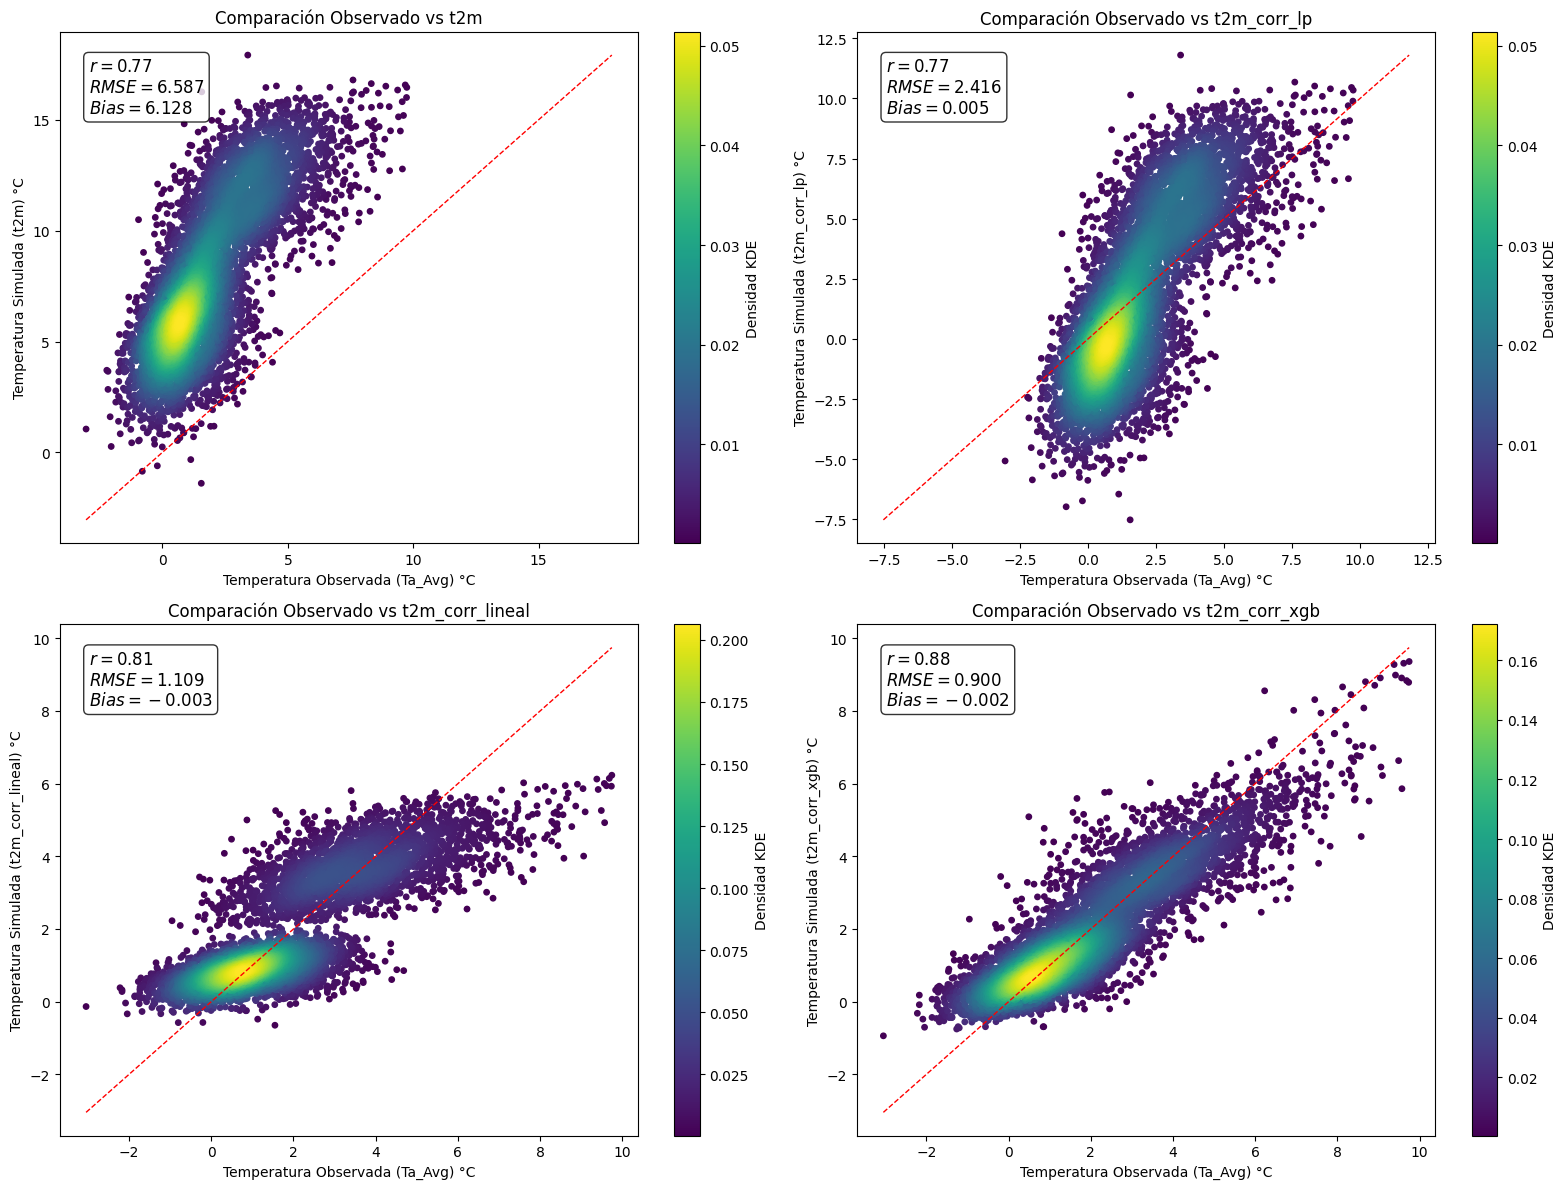

In [27]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['t2m', 't2m_corr_lp', 't2m_corr_lineal', 't2m_corr_xgb']

plt.figure(figsize=(16, 12))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_t2[['Ta_Avg', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(2, 2, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('Temperatura Observada (Ta_Avg) °C')
    ax.set_ylabel(f'Temperatura Simulada ({var}) °C')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


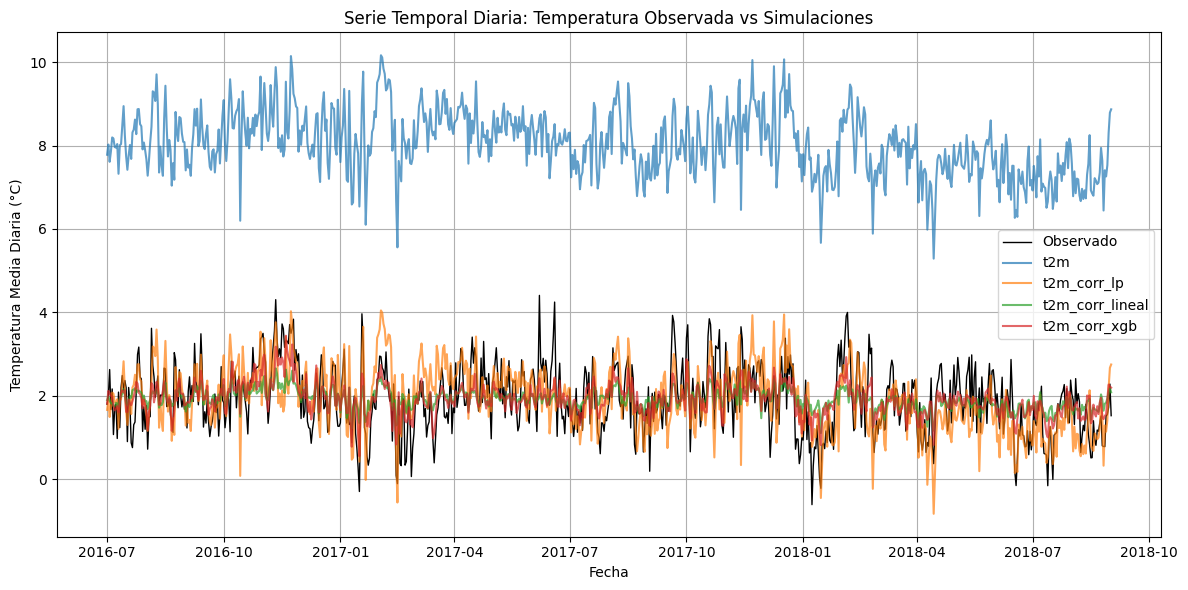

In [28]:
# Lista de variables simuladas
sim_vars = ['t2m', 't2m_corr_lp', 't2m_corr_lineal', 't2m_corr_xgb']

# Asegurarse de que el índice es datetime
df_t2.index = pd.to_datetime(df_t2.index)

# Agrupar por día y calcular la media
df_daily = df_t2[['Ta_Avg'] + sim_vars].resample('D').mean().dropna()

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar observaciones
plt.plot(df_daily.index, df_daily['Ta_Avg'], label='Observado', color='black', linewidth=1)

# Graficar simulaciones
for var in sim_vars:
    plt.plot(df_daily.index, df_daily[var], label=var, alpha=0.7)

# Personalizar gráfico
plt.title('Serie Temporal Diaria: Temperatura Observada vs Simulaciones')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Media Diaria (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Escalamiento ERA5 para SWin

In [29]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'SWin_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['ssrd', 't2m', 'rh', 'z', 'ele_aws', 'SWin_Avg']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['ssrd', 't2m', 'rh', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['SWin_Avg']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [30]:
print(X_train)

                           ssrd        t2m         rh            z  ele_aws
valid_time                                                                 
2017-05-28 21:00:00  282.299347  10.415192  69.325432  3875.140381     4817
2018-05-06 15:00:00  571.440857   9.805817  65.265976  3875.140381     4817
2016-11-24 09:00:00    0.000000   3.985992  93.110001  3875.140381     4817
2018-03-13 00:00:00    4.662774   7.412750  96.810143  3875.140381     4817
2018-07-26 06:00:00    0.000000   3.604889  77.419258  3875.140381     4817
...                         ...        ...        ...          ...      ...
2017-10-15 15:00:00  530.102234  10.173737  72.619431  3875.140381     4817
2018-04-11 00:00:00    0.440894   6.563629  95.065544  3875.140381     4817
2018-04-15 09:00:00    0.000000   2.945465  96.162987  3875.140381     4817
2018-05-05 21:00:00  400.868042  11.571442  80.430420  3875.140381     4817
2016-10-16 15:00:00  519.113342   9.963043  68.181526  3875.140381     4817

[5069 rows 

In [31]:
print(y_train)

valid_time
2017-05-28 21:00:00      99.621318
2018-05-06 15:00:00    1088.771883
2016-11-24 09:00:00       3.847539
2018-03-13 00:00:00       0.015989
2018-07-26 06:00:00       0.000000
                          ...     
2017-10-15 15:00:00     346.049950
2018-04-11 00:00:00       0.000000
2018-04-15 09:00:00       0.788368
2018-05-05 21:00:00      73.015328
2016-10-16 15:00:00     633.506267
Name: SWin_Avg, Length: 5069, dtype: float64


In [32]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.0f} W/m²")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 168 W/m²
[Regresión Lineal] R²: 0.71


In [33]:
X_full = df_era5_aws[vars].drop(columns=['SWin_Avg'])
df_era5_aws['SWin_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  Ta_Avg  Rh_Avg  WiSp  pressure  precip_Tot  \
valid_time           ...                                               
2016-01-01 00:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2016-01-01 03:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2016-01-01 06:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2016-01-01 09:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2016-01-01 12:00:00  ...     NaN     NaN   NaN       NaN         NaN   
...                  ...     ...     ...   ...       ...         ...   
2018-12-31 09:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2018-12-31 12:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2018-12-31 15:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2018-12-31 18:00:00  ...     NaN     NaN   NaN       NaN         NaN   
2018-12-31 21:00:00  ...     NaN     NaN   NaN       NaN         NaN   

                     t2m_corr_lp  ele_aws  t2m_corr_lineal  t2m_corr_xgb  \
valid_time                                                                 
2016-01-01 00:00:00     3.738417     4817         1.659148      1.632994   
2016-01-01 03:00:00     2.826551     4817         1.495377      1.737234   
2016-01-01 06:00:00     1.205214     4817         1.169642      1.154999   
2016-01-01 09:00:00     0.663954     4817         1.039193      0.864530   
2016-01-01 12:00:00     2.320204     4817         1.621121      1.985084   
...                          ...      ...              ...           ...   
2018-12-31 09:00:00    -1.960070     4817         0.439488      0.376000   
2018-12-31 12:00:00     0.707899     4817         1.191571      1.185451   
2018-12-31 15:00:00     5.172255     4817         3.918464      3.597916   
2018-12-31 18:00:00     7.493788     4817         4.849415      5.152278   
2018-12-31 21:00:00     4.989637     4817         2.996085      3.185483   

                     SWin_corr_lineal  
vali

In [34]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.0f} °W/m²")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 125 °W/m²
[XGBoost] R²: 0.84


In [35]:
X_full = df_era5_aws[vars].drop(columns=['SWin_Avg'])
df_era5_aws['SWin_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  Rh_Avg  WiSp  pressure  precip_Tot  t2m_corr_lp  \
valid_time           ...                                                    
2016-01-01 00:00:00  ...     NaN   NaN       NaN         NaN     3.738417   
2016-01-01 03:00:00  ...     NaN   NaN       NaN         NaN     2.826551   
2016-01-01 06:00:00  ...     NaN   NaN       NaN         NaN     1.205214   
2016-01-01 09:00:00  ...     NaN   NaN       NaN         NaN     0.663954   
2016-01-01 12:00:00  ...     NaN   NaN       NaN         NaN     2.320204   
...                  ...     ...   ...       ...         ...          ...   
2018-12-31 09:00:00  ...     NaN   NaN       NaN         NaN    -1.960070   
2018-12-31 12:00:00  ...     NaN   NaN       NaN         NaN     0.707899   
2018-12-31 15:00:00  ...     NaN   NaN       NaN         NaN     5.172255   
2018-12-31 18:00:00  ...     NaN   NaN       NaN         NaN     7.493788   
2018-12-31 21:00:00  ...     NaN   NaN       NaN         NaN     4.989637   

                     ele_aws  t2m_corr_lineal  t2m_corr_xgb  SWin_corr_lineal  \
valid_time                                                                      
2016-01-01 00:00:00     4817         1.659148      1.632994       -104.476412   
2016-01-01 03:00:00     4817         1.495377      1.737234        -92.197353   
2016-01-01 06:00:00     4817         1.169642      1.154999        -35.555285   
2016-01-01 09:00:00     4817         1.039193      0.864530        -12.295235   
2016-01-01 12:00:00     4817         1.621121      1.985084         32.488646   
...                      ...              ...           ...               ...   
2018-12-31 09:00:00     4817         0.439488      0.376000         82.355739   
2018-12-31 12:00:00     4817         1.191571      1.185451         62.380901   
2018-12-31 15:00:00     4817         3.918464      3.597916        650.852288   
2018-12-31 18:00:00     4817         4.849415      5.152278        730.790840

In [36]:
vars_SWin = ['SWin_Avg', 'ssrd', 'SWin_corr_lineal', 'SWin_corr_xgb']
df_SWin = df_era5_aws[vars_SWin].resample('1d').mean()
df_SWin

SWin_Avg        ssrd  SWin_corr_lineal  SWin_corr_xgb
valid_time                                                       
2016-01-01       NaN  309.175049        210.125290     242.415649
2016-01-02       NaN  322.289307        275.950823     342.484131
2016-01-03       NaN  277.524292        208.663353     232.770081
2016-01-04       NaN  245.044739        162.302094     213.025742
2016-01-05       NaN  207.461090         82.204844     116.540138
...              ...         ...               ...            ...
2018-12-27       NaN  235.135284        194.511731     232.482193
2018-12-28       NaN  243.469284        189.889838     182.531418
2018-12-29       NaN  267.843445        215.376997     212.114960
2018-12-30       NaN  289.653900        242.465695     257.773651
2018-12-31       NaN  265.822754        225.660728     241.658020

[1096 rows x 4 columns]

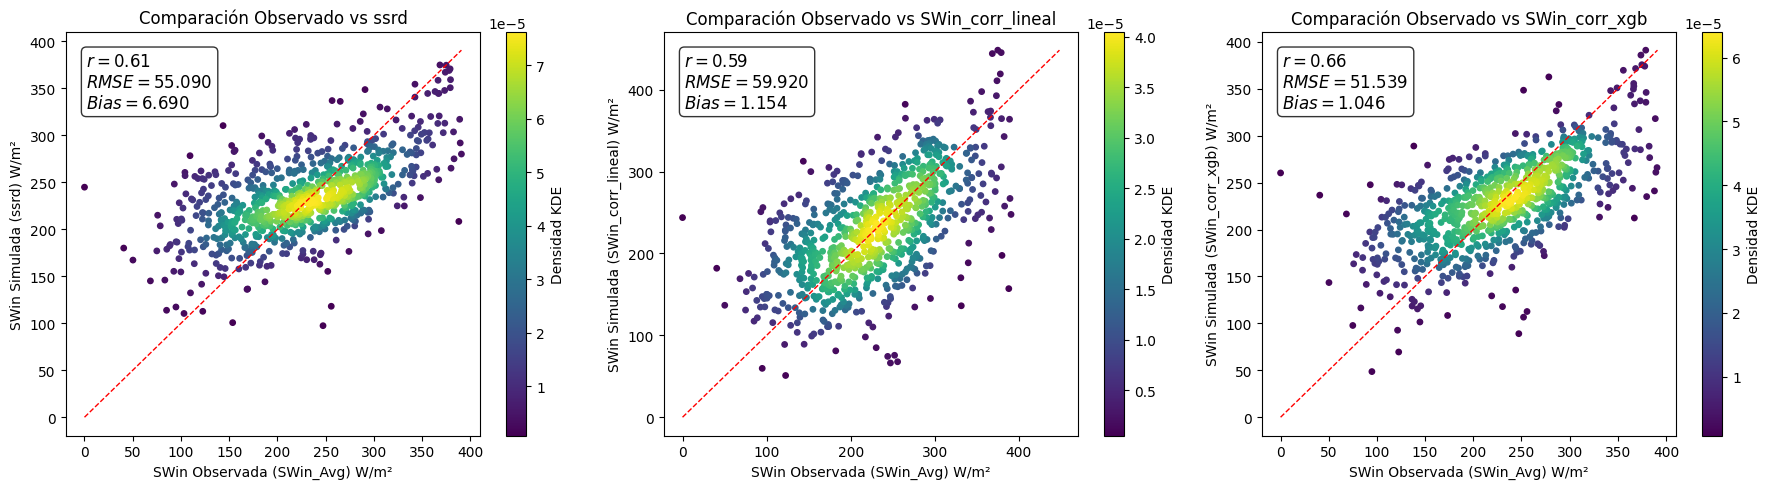

In [37]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['ssrd', 'SWin_corr_lineal', 'SWin_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_SWin[['SWin_Avg', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('SWin Observada (SWin_Avg) W/m²')
    ax.set_ylabel(f'SWin Simulada ({var}) W/m²')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


### Escalamiento humedad relativa

In [38]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'ws2': velocidad del viento (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Rh_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['rh', 'ssrd', 't2m', 'ws2', 'z', 'ele_aws', 'Rh_Avg']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['rh', 'ssrd', 't2m', 'ws2', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['Rh_Avg']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [39]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.0f} %")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 14 %
[Regresión Lineal] R²: 0.53


In [40]:
X_full = df_era5_aws[vars].drop(columns=['Rh_Avg'])
df_era5_aws['Rh_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  WiSp  pressure  precip_Tot  t2m_corr_lp  ele_aws  \
valid_time           ...                                                     
2016-01-01 00:00:00  ...   NaN       NaN         NaN     3.738417     4817   
2016-01-01 03:00:00  ...   NaN       NaN         NaN     2.826551     4817   
2016-01-01 06:00:00  ...   NaN       NaN         NaN     1.205214     4817   
2016-01-01 09:00:00  ...   NaN       NaN         NaN     0.663954     4817   
2016-01-01 12:00:00  ...   NaN       NaN         NaN     2.320204     4817   
...                  ...   ...       ...         ...          ...      ...   
2018-12-31 09:00:00  ...   NaN       NaN         NaN    -1.960070     4817   
2018-12-31 12:00:00  ...   NaN       NaN         NaN     0.707899     4817   
2018-12-31 15:00:00  ...   NaN       NaN         NaN     5.172255     4817   
2018-12-31 18:00:00  ...   NaN       NaN         NaN     7.493788     4817   
2018-12-31 21:00:00  ...   NaN       NaN         NaN     4.989637     4817   

                     t2m_corr_lineal  t2m_corr_xgb  SWin_corr_lineal  \
valid_time                                                             
2016-01-01 00:00:00         1.659148      1.632994       -104.476412   
2016-01-01 03:00:00         1.495377      1.737234        -92.197353   
2016-01-01 06:00:00         1.169642      1.154999        -35.555285   
2016-01-01 09:00:00         1.039193      0.864530        -12.295235   
2016-01-01 12:00:00         1.621121      1.985084         32.488646   
...                              ...           ...               ...   
2018-12-31 09:00:00         0.439488      0.376000         82.355739   
2018-12-31 12:00:00         1.191571      1.185451         62.380901   
2018-12-31 15:00:00         3.918464      3.597916        650.852288   
2018-12-31 18:00:00         4.849415      5.152278        730.790840   
2018-12-31 21:00:00         2.996085      3.185483        345.369120   

                  

In [41]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.0f} %")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 13 %
[XGBoost] R²: 0.64


In [42]:
X_full = df_era5_aws[vars].drop(columns=['Rh_Avg'])
df_era5_aws['Rh_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  pressure  precip_Tot  t2m_corr_lp  ele_aws  \
valid_time           ...                                               
2016-01-01 00:00:00  ...       NaN         NaN     3.738417     4817   
2016-01-01 03:00:00  ...       NaN         NaN     2.826551     4817   
2016-01-01 06:00:00  ...       NaN         NaN     1.205214     4817   
2016-01-01 09:00:00  ...       NaN         NaN     0.663954     4817   
2016-01-01 12:00:00  ...       NaN         NaN     2.320204     4817   
...                  ...       ...         ...          ...      ...   
2018-12-31 09:00:00  ...       NaN         NaN    -1.960070     4817   
2018-12-31 12:00:00  ...       NaN         NaN     0.707899     4817   
2018-12-31 15:00:00  ...       NaN         NaN     5.172255     4817   
2018-12-31 18:00:00  ...       NaN         NaN     7.493788     4817   
2018-12-31 21:00:00  ...       NaN         NaN     4.989637     4817   

                     t2m_corr_lineal  t2m_corr_xgb  SWin_corr_lineal  \
valid_time                                                             
2016-01-01 00:00:00         1.659148      1.632994       -104.476412   
2016-01-01 03:00:00         1.495377      1.737234        -92.197353   
2016-01-01 06:00:00         1.169642      1.154999        -35.555285   
2016-01-01 09:00:00         1.039193      0.864530        -12.295235   
2016-01-01 12:00:00         1.621121      1.985084         32.488646   
...                              ...           ...               ...   
2018-12-31 09:00:00         0.439488      0.376000         82.355739   
2018-12-31 12:00:00         1.191571      1.185451         62.380901   
2018-12-31 15:00:00         3.918464      3.597916        650.852288   
2018-12-31 18:00:00         4.849415      5.152278        730.790840   
2018-12-31 21:00:00         2.996085      3.185483        345.369120   

                     SWin_corr_xgb  Rh_corr_lineal  Rh_corr_xgb  
valid_time                    

In [43]:
vars_rh = ['Rh_Avg', 'rh', 'Rh_corr_lineal', 'Rh_corr_xgb']
df_rh = df_era5_aws[vars_rh]#.resample('1d').mean()
df_rh

Rh_Avg         rh  Rh_corr_lineal  Rh_corr_xgb
valid_time                                                         
2016-01-01 00:00:00     NaN  88.779968       99.421893    90.776306
2016-01-01 03:00:00     NaN  91.838936       99.773502    97.162392
2016-01-01 06:00:00     NaN  94.054993       95.657391    97.466064
2016-01-01 09:00:00     NaN  93.262016       93.127620    94.966026
2016-01-01 12:00:00     NaN  82.930542       86.491968    84.876038
...                     ...        ...             ...          ...
2018-12-31 09:00:00     NaN  95.798843       80.928927    85.393997
2018-12-31 12:00:00     NaN  86.473648       78.737596    80.301262
2018-12-31 15:00:00     NaN  66.027306       67.131856    70.806992
2018-12-31 18:00:00     NaN  72.671013       83.235442    72.446297
2018-12-31 21:00:00     NaN  82.226036       87.547480    87.701874

[8768 rows x 4 columns]

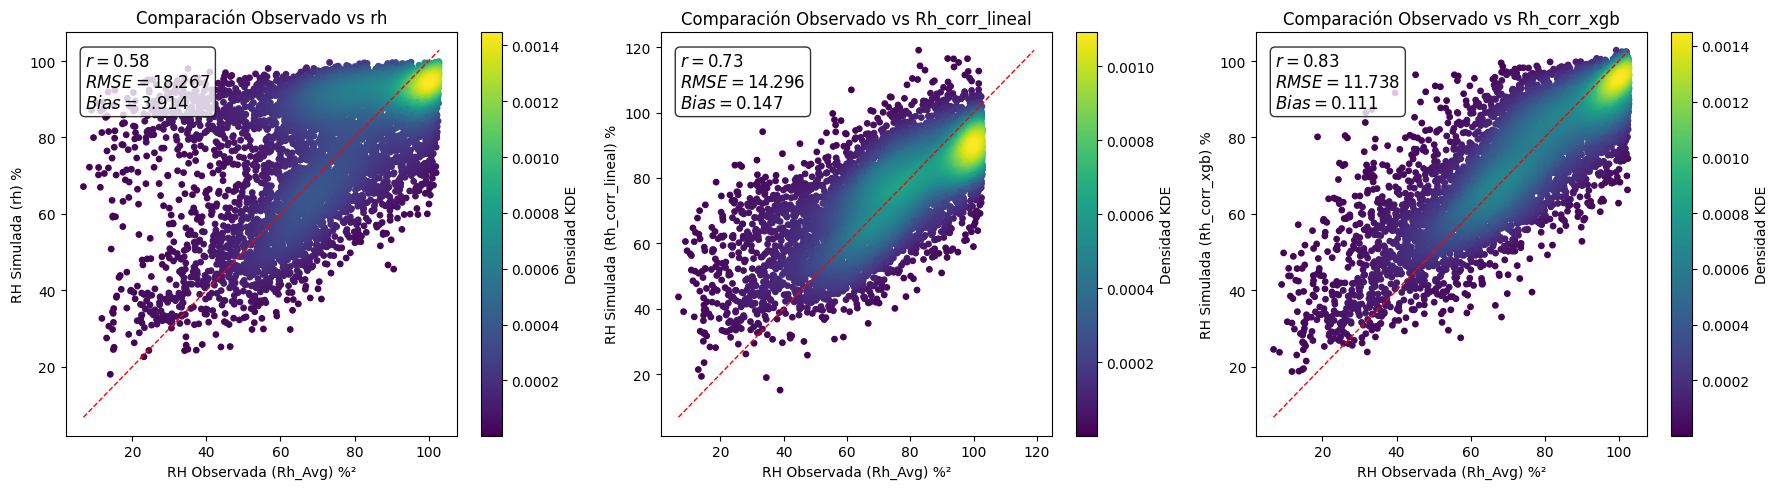

In [44]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['rh', 'Rh_corr_lineal', 'Rh_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_rh[['Rh_Avg', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('RH Observada (Rh_Avg) %²')
    ax.set_ylabel(f'RH Simulada ({var}) %')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


### Presion del aire

In [45]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'ws2': velocidad del viento (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Rh_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['sp', 't2m', 'ssrd', 'z', 'ele_aws', 'pressure']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['sp', 't2m', 'ssrd', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['pressure']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [46]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.2f} hPa")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 0.79 hPa
[Regresión Lineal] R²: 0.81


In [47]:
X_full = df_era5_aws[vars].drop(columns=['pressure'])
df_era5_aws['sp_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  precip_Tot  t2m_corr_lp  ele_aws  t2m_corr_lineal  \
valid_time           ...                                                      
2016-01-01 00:00:00  ...         NaN     3.738417     4817         1.659148   
2016-01-01 03:00:00  ...         NaN     2.826551     4817         1.495377   
2016-01-01 06:00:00  ...         NaN     1.205214     4817         1.169642   
2016-01-01 09:00:00  ...         NaN     0.663954     4817         1.039193   
2016-01-01 12:00:00  ...         NaN     2.320204     4817         1.621121   
...                  ...         ...          ...      ...              ...   
2018-12-31 09:00:00  ...         NaN    -1.960070     4817         0.439488   
2018-12-31 12:00:00  ...         NaN     0.707899     4817         1.191571   
2018-12-31 15:00:00  ...         NaN     5.172255     4817         3.918464   
2018-12-31 18:00:00  ...         NaN     7.493788     4817         4.849415   
2018-12-31 21:00:00  ...         NaN     4.989637     4817         2.996085   

                     t2m_corr_xgb  SWin_corr_lineal  SWin_corr_xgb  \
valid_time                                                           
2016-01-01 00:00:00      1.632994       -104.476412      -1.810963   
2016-01-01 03:00:00      1.737234        -92.197353      -0.982423   
2016-01-01 06:00:00      1.154999        -35.555285      -0.892537   
2016-01-01 09:00:00      0.864530        -12.295235       0.182033   
2016-01-01 12:00:00      1.985084         32.488646     349.597076   
...                           ...               ...            ...   
2018-12-31 09:00:00      0.376000         82.355739       0.568083   
2018-12-31 12:00:00      1.185451         62.380901     314.910522   
2018-12-31 15:00:00      3.597916        650.852288     728.185303   
2018-12-31 18:00:00      5.152278        730.790840     640.942261   
2018-12-31 21:00:00      3.185483        345.369120     223.943161   

                     Rh_corr_li

In [48]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.2f} hPa")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 0.71 hPa
[XGBoost] R²: 0.85


In [49]:
X_full = df_era5_aws[vars].drop(columns=['pressure'])
df_era5_aws['sp_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  t2m_corr_lp  ele_aws  t2m_corr_lineal  t2m_corr_xgb  \
valid_time           ...                                                        
2016-01-01 00:00:00  ...     3.738417     4817         1.659148      1.632994   
2016-01-01 03:00:00  ...     2.826551     4817         1.495377      1.737234   
2016-01-01 06:00:00  ...     1.205214     4817         1.169642      1.154999   
2016-01-01 09:00:00  ...     0.663954     4817         1.039193      0.864530   
2016-01-01 12:00:00  ...     2.320204     4817         1.621121      1.985084   
...                  ...          ...      ...              ...           ...   
2018-12-31 09:00:00  ...    -1.960070     4817         0.439488      0.376000   
2018-12-31 12:00:00  ...     0.707899     4817         1.191571      1.185451   
2018-12-31 15:00:00  ...     5.172255     4817         3.918464      3.597916   
2018-12-31 18:00:00  ...     7.493788     4817         4.849415      5.152278   
2018-12-31 21:00:00  ...     4.989637     4817         2.996085      3.185483   

                     SWin_corr_lineal  SWin_corr_xgb  Rh_corr_lineal  \
valid_time                                                             
2016-01-01 00:00:00       -104.476412      -1.810963       99.421893   
2016-01-01 03:00:00        -92.197353      -0.982423       99.773502   
2016-01-01 06:00:00        -35.555285      -0.892537       95.657391   
2016-01-01 09:00:00        -12.295235       0.182033       93.127620   
2016-01-01 12:00:00         32.488646     349.597076       86.491968   
...                               ...            ...             ...   
2018-12-31 09:00:00         82.355739       0.568083       80.928927   
2018-12-31 12:00:00         62.380901     314.910522       78.737596   
2018-12-31 15:00:00        650.852288     728.185303       67.131856   
2018-12-31 18:00:00        730.790840     640.942261       83.235442   
2018-12-31 21:00:00        345.369120     223.943161

In [50]:
vars_sp = ['pressure', 'sp', 'sp_corr_lineal', 'sp_corr_xgb']
df_sp = df_era5_aws[vars_sp]#.resample('1d').mean()
df_sp

pressure          sp  sp_corr_lineal  sp_corr_xgb
valid_time                                                            
2016-01-01 00:00:00       NaN  641.328186      575.144941   575.306641
2016-01-01 03:00:00       NaN  642.770386      577.109071   577.546387
2016-01-01 06:00:00       NaN  641.563782      574.846039   574.924194
2016-01-01 09:00:00       NaN  640.537720      573.151516   572.743469
2016-01-01 12:00:00       NaN  641.394897      574.668257   575.172913
...                       ...         ...             ...          ...
2018-12-31 09:00:00       NaN  639.323303      570.601467   570.480286
2018-12-31 12:00:00       NaN  640.620728      573.124349   573.358154
2018-12-31 15:00:00       NaN  641.011292      572.913919   572.598511
2018-12-31 18:00:00       NaN  639.818848      571.211140   570.761963
2018-12-31 21:00:00       NaN  638.383850      569.671986   570.157959

[8768 rows x 4 columns]

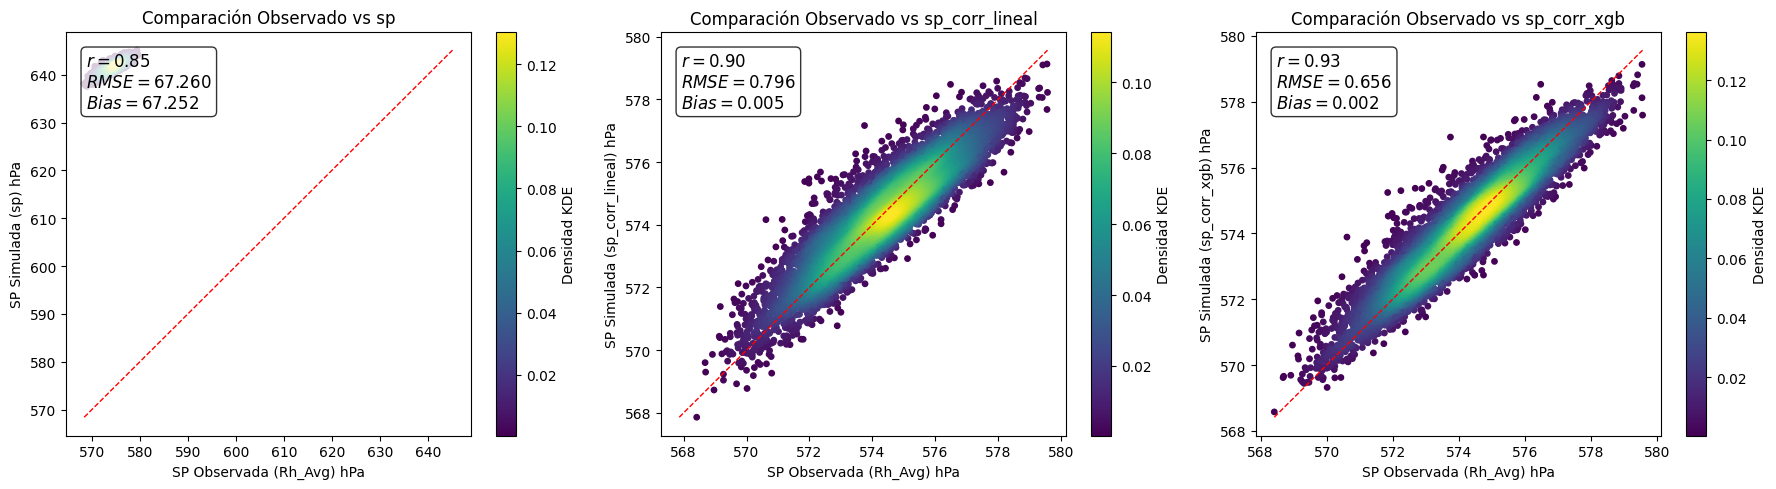

In [51]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['sp', 'sp_corr_lineal', 'sp_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_sp[['pressure', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('SP Observada (Rh_Avg) hPa')
    ax.set_ylabel(f'SP Simulada ({var}) hPa')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


### Velocidad del viento

In [52]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'ws2': velocidad del viento (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Rh_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['ws2', 'u10', 'v10', 't2m', 'ssrd', 'sp', 'z', 'ele_aws', 'WiSp']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['ws2', 'u10', 'v10', 't2m', 'ssrd', 'sp', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['WiSp']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [ ]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.2f} m/s")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 2.22 hPa
[Regresión Lineal] R²: 0.47


In [54]:
X_full = df_era5_aws[vars].drop(columns=['WiSp'])
df_era5_aws['ws2_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  ele_aws  t2m_corr_lineal  t2m_corr_xgb  \
valid_time           ...                                           
2016-01-01 00:00:00  ...     4817         1.659148      1.632994   
2016-01-01 03:00:00  ...     4817         1.495377      1.737234   
2016-01-01 06:00:00  ...     4817         1.169642      1.154999   
2016-01-01 09:00:00  ...     4817         1.039193      0.864530   
2016-01-01 12:00:00  ...     4817         1.621121      1.985084   
...                  ...      ...              ...           ...   
2018-12-31 09:00:00  ...     4817         0.439488      0.376000   
2018-12-31 12:00:00  ...     4817         1.191571      1.185451   
2018-12-31 15:00:00  ...     4817         3.918464      3.597916   
2018-12-31 18:00:00  ...     4817         4.849415      5.152278   
2018-12-31 21:00:00  ...     4817         2.996085      3.185483   

                     SWin_corr_lineal  SWin_corr_xgb  Rh_corr_lineal  \
valid_time                                                             
2016-01-01 00:00:00       -104.476412      -1.810963       99.421893   
2016-01-01 03:00:00        -92.197353      -0.982423       99.773502   
2016-01-01 06:00:00        -35.555285      -0.892537       95.657391   
2016-01-01 09:00:00        -12.295235       0.182033       93.127620   
2016-01-01 12:00:00         32.488646     349.597076       86.491968   
...                               ...            ...             ...   
2018-12-31 09:00:00         82.355739       0.568083       80.928927   
2018-12-31 12:00:00         62.380901     314.910522       78.737596   
2018-12-31 15:00:00        650.852288     728.185303       67.131856   
2018-12-31 18:00:00        730.790840     640.942261       83.235442   
2018-12-31 21:00:00        345.369120     223.943161       87.547480   

                     Rh_corr_xgb  sp_corr_lineal  sp_corr_xgb  ws2_corr_lineal  
valid_time                                                         

In [56]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.2f} m/s")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 2.04 m/s
[XGBoost] R²: 0.55


In [57]:
X_full = df_era5_aws[vars].drop(columns=['WiSp'])
df_era5_aws['ws2_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                     ...  t2m_corr_lineal  t2m_corr_xgb  SWin_corr_lineal  \
valid_time           ...                                                    
2016-01-01 00:00:00  ...         1.659148      1.632994       -104.476412   
2016-01-01 03:00:00  ...         1.495377      1.737234        -92.197353   
2016-01-01 06:00:00  ...         1.169642      1.154999        -35.555285   
2016-01-01 09:00:00  ...         1.039193      0.864530        -12.295235   
2016-01-01 12:00:00  ...         1.621121      1.985084         32.488646   
...                  ...              ...           ...               ...   
2018-12-31 09:00:00  ...         0.439488      0.376000         82.355739   
2018-12-31 12:00:00  ...         1.191571      1.185451         62.380901   
2018-12-31 15:00:00  ...         3.918464      3.597916        650.852288   
2018-12-31 18:00:00  ...         4.849415      5.152278        730.790840   
2018-12-31 21:00:00  ...         2.996085      3.185483        345.369120   

                     SWin_corr_xgb  Rh_corr_lineal  Rh_corr_xgb  \
valid_time                                                        
2016-01-01 00:00:00      -1.810963       99.421893    90.776306   
2016-01-01 03:00:00      -0.982423       99.773502    97.162392   
2016-01-01 06:00:00      -0.892537       95.657391    97.466064   
2016-01-01 09:00:00       0.182033       93.127620    94.966026   
2016-01-01 12:00:00     349.597076       86.491968    84.876038   
...                            ...             ...          ...   
2018-12-31 09:00:00       0.568083       80.928927    85.393997   
2018-12-31 12:00:00     314.910522       78.737596    80.301262   
2018-12-31 15:00:00     728.185303       67.131856    70.806992   
2018-12-31 18:00:00     640.942261       83.235442    72.446297   
2018-12-31 21:00:00     223.943161       87.547480    87.701874   

                     sp_corr_lineal  sp_corr_xgb  ws2_corr_lineal  \
valid_time                 

In [59]:
vars_ws2 = ['WiSp', 'ws2', 'ws2_corr_lineal', 'ws2_corr_xgb']
df_ws2 = df_era5_aws[vars_ws2]#.resample('1d').mean()
df_ws2

WiSp       ws2  ws2_corr_lineal  ws2_corr_xgb
valid_time                                                        
2016-01-01 00:00:00   NaN  0.734944         0.404485      1.330591
2016-01-01 03:00:00   NaN  0.555618         2.102508      1.520380
2016-01-01 06:00:00   NaN  0.398775         1.620525      1.194852
2016-01-01 09:00:00   NaN  0.207715         0.877436      1.206251
2016-01-01 12:00:00   NaN  0.480782         2.087654      1.955251
...                   ...       ...              ...           ...
2018-12-31 09:00:00   NaN  0.968212         3.233679      2.579105
2018-12-31 12:00:00   NaN  1.614325         5.553829      2.879278
2018-12-31 15:00:00   NaN  1.206408         6.124470      5.979820
2018-12-31 18:00:00   NaN  1.025051         5.209855      4.843325
2018-12-31 21:00:00   NaN  1.462325         3.172093      3.483334

[8768 rows x 4 columns]

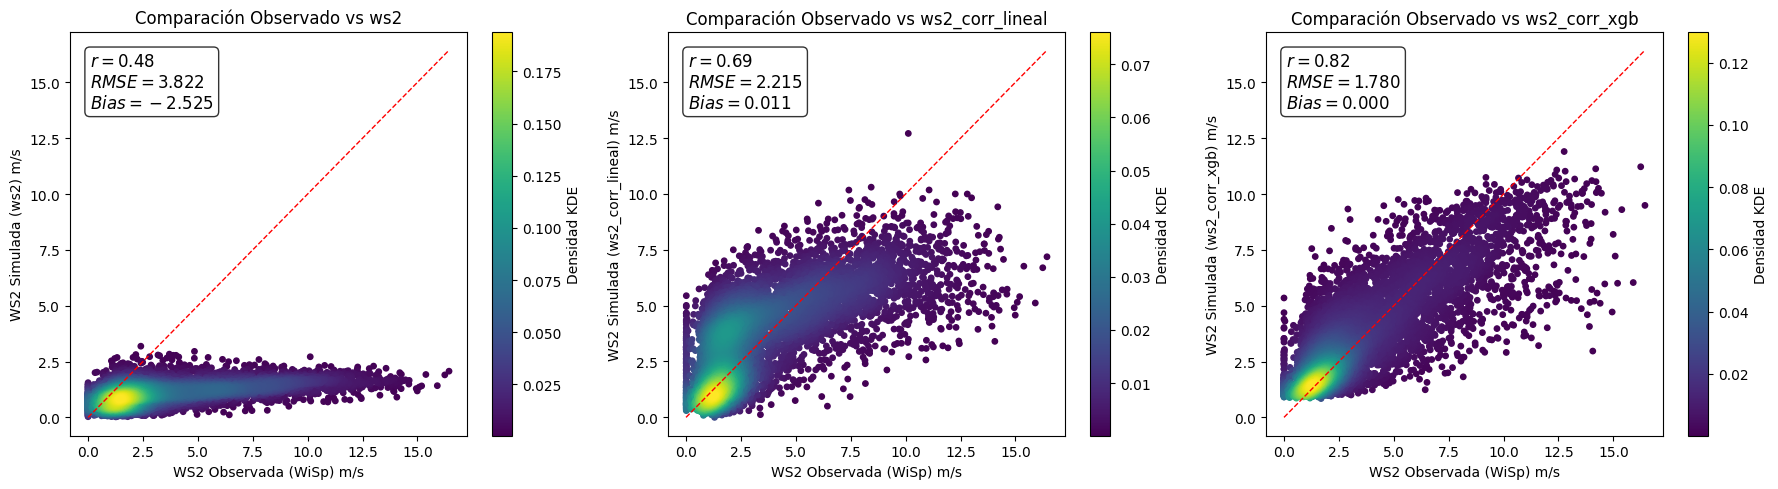

In [61]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['ws2', 'ws2_corr_lineal', 'ws2_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_ws2[['WiSp', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('WS2 Observada (WiSp) m/s')
    ax.set_ylabel(f'WS2 Simulada ({var}) m/s')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


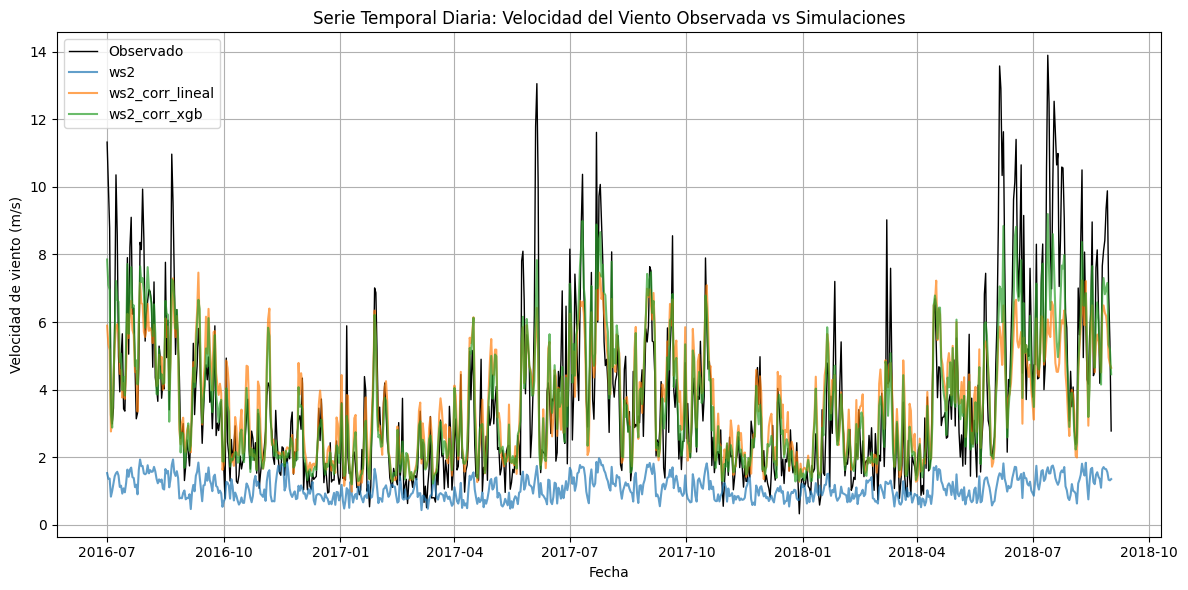

In [63]:
# Lista de variables simuladas
sim_vars = ['ws2', 'ws2_corr_lineal', 'ws2_corr_xgb']

# Asegurarse de que el índice es datetime
df_ws2.index = pd.to_datetime(df_ws2.index)

# Agrupar por día y calcular la media
df_daily = df_ws2[['WiSp'] + sim_vars].resample('D').mean().dropna()

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar observaciones
plt.plot(df_daily.index, df_daily['WiSp'], label='Observado', color='black', linewidth=1)

# Graficar simulaciones
for var in sim_vars:
    plt.plot(df_daily.index, df_daily[var], label=var, alpha=0.7)

# Personalizar gráfico
plt.title('Serie Temporal Diaria: Velocidad del Viento Observada vs Simulaciones')
plt.xlabel('Fecha')
plt.ylabel('Velocidad de viento (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Correcion incluyendo un analisis climatico

In [85]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'ws2': velocidad del viento (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Rh_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['ws2', 'u10', 'v10', 't2m', 'ssrd', 'sp', 'z', 'ele_aws', 'WiSp']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws = df_era5_aws[vars].copy()#.dropna()
df_era5_aws


ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  
valid_time                                                   
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN  
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN  
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN  
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN  
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN  
...                         ...          ...      ...   ...  
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN  
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN  
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN  
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN  
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN  

[8768 rows x 9 columns]

In [86]:
df_era5_aws['day_of_year'] = df_era5_aws.index.dayofyear
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  day_of_year  
valid_time                                                                
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN            1  
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN            1  
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN            1  
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN            1  
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN            1  
...                         ...          ...      ...   ...          ...  
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN          365  
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN          365  
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN          365  
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN          365  
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN          365  

[8768 rows x 10 columns]

In [87]:
df_era5_aws['hour_group'] = (df_era5_aws.index.hour // 3) * 3
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  day_of_year  \
valid_time                                                                 
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN            1   
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN            1   
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN            1   
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN            1   
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN            1   
...                         ...          ...      ...   ...          ...   
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN          365   
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN          365   
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN          365   
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN          365   
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN          365   

                     hour_group  
valid_time                       
2016-01-01 00:00:00           0  
2016-01-01 03:00:00           3  
2016-01-01 06:00:00           6  
2016-01-01 09:00:00           9  
2016-01-01 12:00:00          12  
...                         ...  
2018-12-31 09:00:00           9  
2018-12-31 12:00:00          12  
2018-12-31 15:00:00          15  
2018-12-31 18:00:00          18  
2018-12-31 21:00:00          21  

[8768 rows x 11 columns]

In [88]:
clim_cols = ['day_of_year', 'hour_group']
hourly_clim = df_era5_aws.groupby(clim_cols)['WiSp'].agg(['mean']).rename(columns={'mean':'WiSp_clim'})
hourly_clim

WiSp_clim
day_of_year hour_group           
1           0            0.417917
            3            0.686667
            6            0.593000
            9            0.581167
            12           1.910667
...                           ...
366         9            0.708667
            12           1.183833
            15           1.382500
            18           2.241000
            21           1.102667

[2928 rows x 1 columns]

<Axes: xlabel='day_of_year,hour_group'>

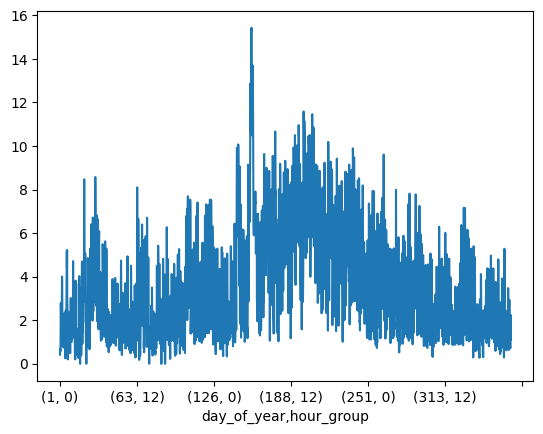

In [89]:
hourly_clim['WiSp_clim'].plot()

In [90]:
df_era5_aws = df_era5_aws.join(hourly_clim, on=clim_cols)
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  day_of_year  \
valid_time                                                                 
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN            1   
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN            1   
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN            1   
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN            1   
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN            1   
...                         ...          ...      ...   ...          ...   
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN          365   
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN          365   
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN          365   
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN          365   
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN          365   

                     hour_group  WiSp_clim  
valid_time                                  
2016-01-01 00:00:00           0   0.417917  
2016-01-01 03:00:00           3   0.686667  
2016-01-01 06:00:00           6   0.593000  
2016-01-01 09:00:00           9   0.581167  
2016-01-01 12:00:00          12   1.910667  
...                         ...        ...  
2018-12-31 09:00:00           9   0.787250  
2018-12-31 12:00:00          12   2.525083  
2018-12-31 15:00:00          15   2.934833  
2018-12-31 18:00:00          18   1.824917  
2018-12-31 21:00:00          21   1.100167  

[8768 rows x 12 columns]

In [91]:
df_era5_aws = df_era5_aws.drop(columns=['day_of_year', 'hour_group'])
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  WiSp_clim  
valid_time                                                              
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN   0.417917  
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN   0.686667  
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN   0.593000  
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN   0.581167  
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN   1.910667  
...                         ...          ...      ...   ...        ...  
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN   0.787250  
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN   2.525083  
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN   2.934833  
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN   1.824917  
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN   1.100167  

[8768 rows x 10 columns]

In [92]:
df_era5_aws_nonan = df_era5_aws.copy().dropna()
# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['ws2', 'WiSp_clim','u10', 'v10', 't2m', 'ssrd', 'sp', 'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['WiSp']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))


5069 1268


In [93]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.2f} m/s")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 1.63 m/s
[Regresión Lineal] R²: 0.71


In [106]:
vars_clim = ['ws2', 'WiSp_clim','u10', 'v10', 't2m', 'ssrd', 'sp', 'z', 'ele_aws']

In [109]:
X_full = df_era5_aws[vars_clim]
df_era5_aws['ws2_clim_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  WiSp_clim  \
valid_time                                                               
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN   0.417917   
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN   0.686667   
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN   0.593000   
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN   0.581167   
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN   1.910667   
...                         ...          ...      ...   ...        ...   
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN   0.787250   
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN   2.525083   
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN   2.934833   
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN   1.824917   
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN   1.100167   

                     ws2_clim_corr_lineal  
valid_time                                 
2016-01-01 00:00:00             -0.350480  
2016-01-01 03:00:00              0.386507  
2016-01-01 06:00:00              0.327976  
2016-01-01 09:00:00              0.154315  
2016-01-01 12:00:00              1.589242  
...                                   ...  
2018-12-31 09:00:00              1.817024  
2018-12-31 12:00:00              4.067828  
2018-12-31 15:00:00              4.004737  
2018-12-31 18:00:00              2.726482  
2018-12-31 21:00:00              1.853707  

[8768 rows x 11 columns]

In [110]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.2f} m/s")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 1.53 m/s
[XGBoost] R²: 0.75


In [111]:
X_full = df_era5_aws[vars_clim]
df_era5_aws['ws2_clim_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

ws2       u10       v10        t2m        ssrd  \
valid_time                                                                 
2016-01-01 00:00:00  0.734944  0.530328 -0.195289   9.860504   13.506380   
2016-01-01 03:00:00  0.555618 -0.403844 -0.139466   8.948639    0.000000   
2016-01-01 06:00:00  0.398775 -0.303594  0.043124   7.327301    0.000000   
2016-01-01 09:00:00  0.207715 -0.153899  0.042744   6.786041    0.000000   
2016-01-01 12:00:00  0.480782 -0.369524  0.011446   8.442291   74.630119   
...                       ...       ...       ...        ...         ...   
2018-12-31 09:00:00  0.968212 -0.716322 -0.202942   4.162018    0.000000   
2018-12-31 12:00:00  1.614325 -1.204952 -0.298395   6.829987   53.449444   
2018-12-31 15:00:00  1.206408 -0.748843 -0.547559  11.294342  712.032776   
2018-12-31 18:00:00  1.025051 -0.284203 -0.735203  13.615875  888.825012   
2018-12-31 21:00:00  1.462325  0.244975 -1.097459  11.111725  462.541107   

                             sp            z  ele_aws  WiSp  WiSp_clim  \
valid_time                                                               
2016-01-01 00:00:00  641.328186  3875.140381     4817   NaN   0.417917   
2016-01-01 03:00:00  642.770386  3875.140381     4817   NaN   0.686667   
2016-01-01 06:00:00  641.563782  3875.140381     4817   NaN   0.593000   
2016-01-01 09:00:00  640.537720  3875.140381     4817   NaN   0.581167   
2016-01-01 12:00:00  641.394897  3875.140381     4817   NaN   1.910667   
...                         ...          ...      ...   ...        ...   
2018-12-31 09:00:00  639.323303  3875.140381     4817   NaN   0.787250   
2018-12-31 12:00:00  640.620728  3875.140381     4817   NaN   2.525083   
2018-12-31 15:00:00  641.011292  3875.140381     4817   NaN   2.934833   
2018-12-31 18:00:00  639.818848  3875.140381     4817   NaN   1.824917   
2018-12-31 21:00:00  638.383850  3875.140381     4817   NaN   1.100167   

                     ws2_clim_corr_lineal  ws2_clim_corr_xgb  
valid_time                                                    
2016-01-01 00:00:00             -0.350480           0.504605  
2016-01-01 03:00:00              0.386507           0.570281  
2016-01-01 06:00:00              0.327976           0.566101  
2016-01-01 09:00:00              0.154315           0.590980  
2016-01-01 12:00:00              1.589242           1.643945  
...                                   ...                ...  
2018-12-31 09:00:00              1.817024           1.313296  
2018-12-31 12:00:00              4.067828           2.849752  
2018-12-31 15:00:00              4.004737           3.883385  
2018-12-31 18:00:00              2.726482           2.338118  
2018-12-31 21:00:00              1.853707           1.579961  

[8768 rows x 12 columns]

In [112]:
vars_ws2 = ['WiSp', 'ws2', 'ws2_clim_corr_lineal', 'ws2_clim_corr_xgb']
df_ws2 = df_era5_aws[vars_ws2]#.resample('1d').mean()
df_ws2

WiSp       ws2  ws2_clim_corr_lineal  ws2_clim_corr_xgb
valid_time                                                                  
2016-01-01 00:00:00   NaN  0.734944             -0.350480           0.504605
2016-01-01 03:00:00   NaN  0.555618              0.386507           0.570281
2016-01-01 06:00:00   NaN  0.398775              0.327976           0.566101
2016-01-01 09:00:00   NaN  0.207715              0.154315           0.590980
2016-01-01 12:00:00   NaN  0.480782              1.589242           1.643945
...                   ...       ...                   ...                ...
2018-12-31 09:00:00   NaN  0.968212              1.817024           1.313296
2018-12-31 12:00:00   NaN  1.614325              4.067828           2.849752
2018-12-31 15:00:00   NaN  1.206408              4.004737           3.883385
2018-12-31 18:00:00   NaN  1.025051              2.726482           2.338118
2018-12-31 21:00:00   NaN  1.462325              1.853707           1.579961

[8768 rows x 4 columns]

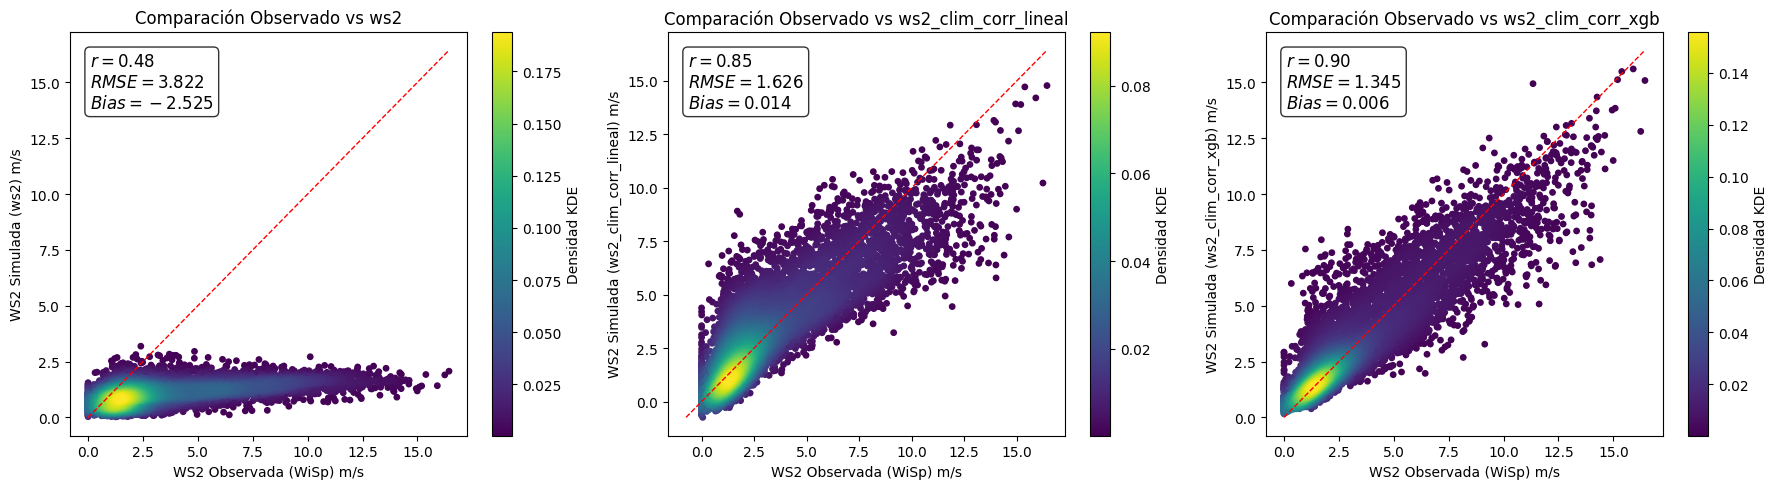

In [113]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['ws2', 'ws2_clim_corr_lineal', 'ws2_clim_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_ws2[['WiSp', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('WS2 Observada (WiSp) m/s')
    ax.set_ylabel(f'WS2 Simulada ({var}) m/s')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


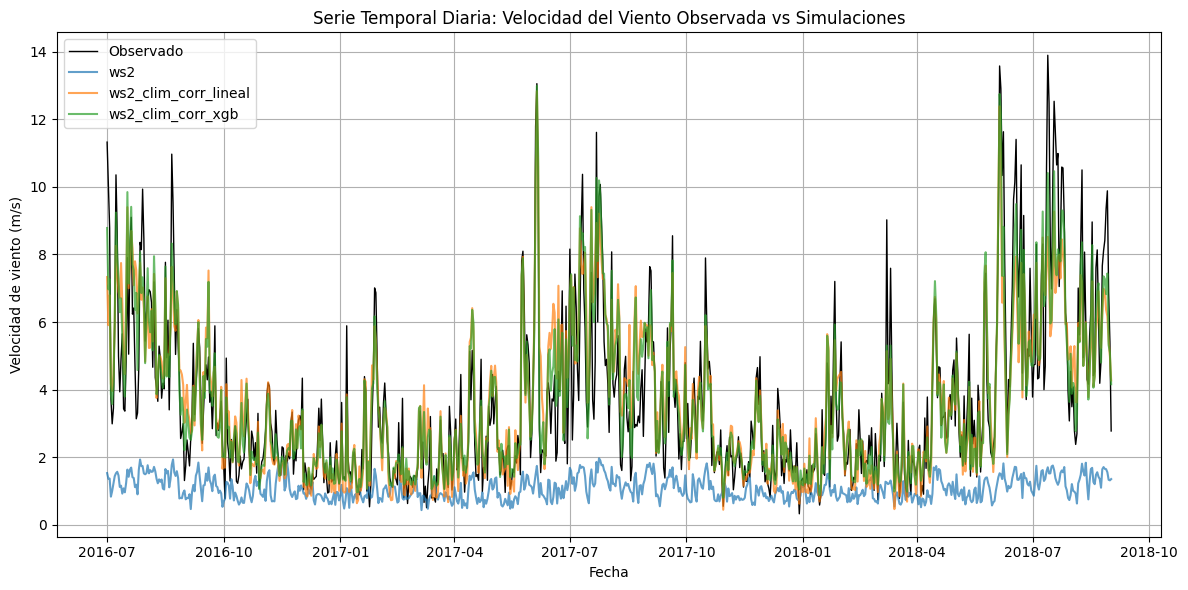

In [114]:
# Lista de variables simuladas
sim_vars = ['ws2', 'ws2_clim_corr_lineal', 'ws2_clim_corr_xgb']

# Asegurarse de que el índice es datetime
df_ws2.index = pd.to_datetime(df_ws2.index)

# Agrupar por día y calcular la media
df_daily = df_ws2[['WiSp'] + sim_vars].resample('D').mean().dropna()

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar observaciones
plt.plot(df_daily.index, df_daily['WiSp'], label='Observado', color='black', linewidth=1)

# Graficar simulaciones
for var in sim_vars:
    plt.plot(df_daily.index, df_daily[var], label=var, alpha=0.7)

# Personalizar gráfico
plt.title('Serie Temporal Diaria: Velocidad del Viento Observada vs Simulaciones')
plt.xlabel('Fecha')
plt.ylabel('Velocidad de viento (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Precipitacion

In [135]:
# -------------------------------
# 1. Preparación de datos
# -------------------------------

# Definir las variables que se utilizarán en el análisis:
# - 't2m': temperatura del aire a 2 metros (ERA5)
# - 'ssrd': radiación solar superficial descendente (ERA5)
# - 'rh': humedad relativa (ERA5)
# - 'ws2': velocidad del viento (ERA5)
# - 'z': altitud del punto ERA5
# - 'ele_aws': altitud de la estación meteorológica
# - 'Rh_Avg': radiación solar media observada en la estación meteorológica
#vars = ['t2m', 'ssrd', 'u10', 'v10', 'Ta_Avg']
vars = ['tp', 't2m', 'ssrd', 'rh',  'z', 'ele_aws', 'precip_Tot']

# Crear una copia del DataFrame original que contenga únicamente las variables seleccionadas y eliminar filas con valores nulos
df_era5_aws_nonan = df_era5_aws[vars].copy().dropna()

# Definir las variables predictoras (features) tomadas de ERA5 y altitud de la estación
#X = df_era5_aws_nonan[['t2m', 'ssrd', 'u10', 'v10']]
X = df_era5_aws_nonan[['tp', 't2m', 'ssrd', 'rh',  'z', 'ele_aws']]

# Definir la variable objetivo: temperatura promedio observada (de la estación)
y = df_era5_aws_nonan['precip_Tot']

# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
# La semilla random_state=42 permite obtener los mismos resultados al ejecutar varias veces
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir el conjunto de prueba (features) para revisar su contenido
print(len(X_train), len(X_test))

5069 1268


In [136]:
# -------------------------------
# 2. Modelo de regresión lineal
# -------------------------------

# Crear una instancia del modelo de regresión lineal de scikit-learn
modelo_lr = LinearRegression()

# Ajustar (entrenar) el modelo usando los datos de entrenamiento
modelo_lr.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_lr = modelo_lr.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los valores reales
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Calcular el coeficiente de determinación R² (explica qué proporción de la varianza se explica por el modelo)
r2_lr = r2_score(y_test, y_pred_lr)

# Imprimir el RMSE con dos decimales, indicando el error promedio de las predicciones
print(f"[Regresión Lineal] RMSE: {rmse_lr:.2f} mm/hr")

# Imprimir el R² con dos decimales, indicando la calidad del ajuste del modelo
print(f"[Regresión Lineal] R²: {r2_lr:.2f}")


[Regresión Lineal] RMSE: 1.06 mm/hr
[Regresión Lineal] R²: 0.09


In [137]:
X_full = df_era5_aws[vars].drop(columns=['precip_Tot'])
df_era5_aws['tp_corr_lineal'] = modelo_lr.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  ele_aws  tp_corr_lineal  
valid_time                                                
2016-01-01 00:00:00         NaN     4817        1.018330  
2016-01-01 03:00:00         NaN     4817        0.918643  
2016-01-01 06:00:00         NaN     4817        0.709962  
2016-01-01 09:00:00         NaN     4817        0.612081  
2016-01-01 12:00:00         NaN     4817        0.523761  
...                         ...      ...             ...  
2018-12-31 09:00:00         NaN     4817        0.373451  
2018-12-31 12:00:00         NaN     4817        0.442285  
2018-12-31 15:00:00         NaN     4817        0.244432  
2018-12-31 18:00:00         NaN     4817        0.643885  
2018-12-31 21:00:00         NaN     4817        0.803004  

[8768 rows x 19 columns]

In [138]:
# -------------------------------
# 4. Modelo XGBoost
# -------------------------------

# Crear un modelo de regresión XGBoost con hiperparámetros definidos:
# - n_estimators=100: número de árboles a construir.
# - learning_rate=0.1: tasa de aprendizaje que controla la contribución de cada árbol.
# - max_depth=4: profundidad máxima de cada árbol (controla la complejidad del modelo).
# - random_state=42: semilla aleatoria para reproducibilidad.
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Entrenar el modelo con los datos de entrenamiento (X_train, y_train)
modelo_xgb.fit(X_train, y_train)

# Usar el modelo entrenado para hacer predicciones sobre los datos de prueba
y_pred_xgb = modelo_xgb.predict(X_test)

# Calcular la raíz del error cuadrático medio (RMSE) entre las predicciones y los datos reales
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calcular el coeficiente de determinación R² (qué tan bien el modelo explica la variabilidad de los datos)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Imprimir el RMSE formateado con dos decimales
print(f"[XGBoost] RMSE: {rmse_xgb:.2f} mm")

# Imprimir el R² formateado con dos decimales
print(f"[XGBoost] R²: {r2_xgb:.2f}")


[XGBoost] RMSE: 1.06 mm
[XGBoost] R²: 0.08


In [139]:
X_full = df_era5_aws[vars].drop(columns=['precip_Tot'])
df_era5_aws['tp_corr_xgb'] = modelo_xgb.predict(X_full)
df_era5_aws

u10       v10         d2m        t2m          sp  \
valid_time                                                                   
2016-01-01 00:00:00  0.530328 -0.195289  280.261719   9.860504  641.328186   
2016-01-01 03:00:00 -0.403844 -0.139466  279.854248   8.948639  642.770386   
2016-01-01 06:00:00 -0.303594  0.043124  278.591797   7.327301  641.563782   
2016-01-01 09:00:00 -0.153899  0.042744  277.933105   6.786041  640.537720   
2016-01-01 12:00:00 -0.369524  0.011446  277.883789   8.442291  641.394897   
...                       ...       ...         ...        ...         ...   
2018-12-31 09:00:00 -0.716322 -0.202942  275.707031   4.162018  639.323303   
2018-12-31 12:00:00 -1.204952 -0.298395  276.898926   6.829987  640.620728   
2018-12-31 15:00:00 -0.748843 -0.547559  277.380859  11.294342  641.011292   
2018-12-31 18:00:00 -0.284203 -0.735203  280.990479  13.615875  639.818848   
2018-12-31 21:00:00  0.244975 -1.097459  280.370361  11.111725  638.383850   

                               z        ssrd        strd        tp       ws2  \
valid_time                                                                     
2016-01-01 00:00:00  3875.140381   13.506380  315.975006  2.400990  0.734944   
2016-01-01 03:00:00  3875.140381    0.000000  328.687775  1.439093  0.555618   
2016-01-01 06:00:00  3875.140381    0.000000  319.031097  0.409542  0.398775   
2016-01-01 09:00:00  3875.140381    0.000000  288.209839  0.171138  0.207715   
2016-01-01 12:00:00  3875.140381   74.630119  309.822510  0.173325  0.480782   
...                          ...         ...         ...       ...       ...   
2018-12-31 09:00:00  3875.140381    0.000000  302.916107  0.074790  0.968212   
2018-12-31 12:00:00  3875.140381   53.449444  307.364990  0.245798  1.614325   
2018-12-31 15:00:00  3875.140381  712.032776  295.858612  0.557032  1.206408   
2018-12-31 18:00:00  3875.140381  888.825012  318.728058  1.128274  1.025051   
2018-12-31 21:00:00  3875.140381  462.541107  333.733887  1.887337  1.462325   

                            rh  SWin_Avg  Ta_Avg  Rh_Avg  WiSp  pressure  \
valid_time                                                                 
2016-01-01 00:00:00  88.779968       NaN     NaN     NaN   NaN       NaN   
2016-01-01 03:00:00  91.838936       NaN     NaN     NaN   NaN       NaN   
2016-01-01 06:00:00  94.054993       NaN     NaN     NaN   NaN       NaN   
2016-01-01 09:00:00  93.262016       NaN     NaN     NaN   NaN       NaN   
2016-01-01 12:00:00  82.930542       NaN     NaN     NaN   NaN       NaN   
...                        ...       ...     ...     ...   ...       ...   
2018-12-31 09:00:00  95.798843       NaN     NaN     NaN   NaN       NaN   
2018-12-31 12:00:00  86.473648       NaN     NaN     NaN   NaN       NaN   
2018-12-31 15:00:00  66.027306       NaN     NaN     NaN   NaN       NaN   
2018-12-31 18:00:00  72.671013       NaN     NaN     NaN   NaN       NaN   
2018-12-31 21:00:00  82.226036       NaN     NaN     NaN   NaN       NaN   

                     precip_Tot  ele_aws  tp_corr_lineal  tp_corr_xgb  
valid_time                                                             
2016-01-01 00:00:00         NaN     4817        1.018330     0.603808  
2016-01-01 03:00:00         NaN     4817        0.918643     1.520332  
2016-01-01 06:00:00         NaN     4817        0.709962     0.726839  
2016-01-01 09:00:00         NaN     4817        0.612081     0.579034  
2016-01-01 12:00:00         NaN     4817        0.523761     0.316903  
...                         ...      ...             ...          ...  
2018-12-31 09:00:00         NaN     4817        0.373451     0.247057  
2018-12-31 12:00:00         NaN     4817        0.442285     0.380262  
2018-12-31 15:00:00         NaN     4817        0.244432     0.037574  
2018-12-31 18:00:00         NaN     4817        0.643885     0.362798  
2018-12-31 21:00:00         NaN     4817        0.803004     0.613143  

[8768 rows x 20 columns]

In [145]:
vars_tp = ['precip_Tot', 'tp', 'tp_corr_lineal', 'tp_corr_xgb']
df_tp = df_era5_aws[vars_tp].resample('1d').mean()
df_tp

precip_Tot        tp  tp_corr_lineal  tp_corr_xgb
valid_time                                                   
2016-01-01         NaN  1.275647        0.724105     0.602448
2016-01-02         NaN  0.288615        0.389159     0.112400
2016-01-03         NaN  0.582917        0.506428     0.202911
2016-01-04         NaN  1.155998        0.719993     0.505458
2016-01-05         NaN  1.746242        0.965542     1.291566
...                ...       ...             ...          ...
2018-12-27         NaN  0.745866        0.590181     0.419700
2018-12-28         NaN  0.778051        0.641435     0.569061
2018-12-29         NaN  1.223935        0.632739     0.479540
2018-12-30         NaN  0.600943        0.533626     0.291177
2018-12-31         NaN  0.525495        0.561610     0.375858

[1096 rows x 4 columns]

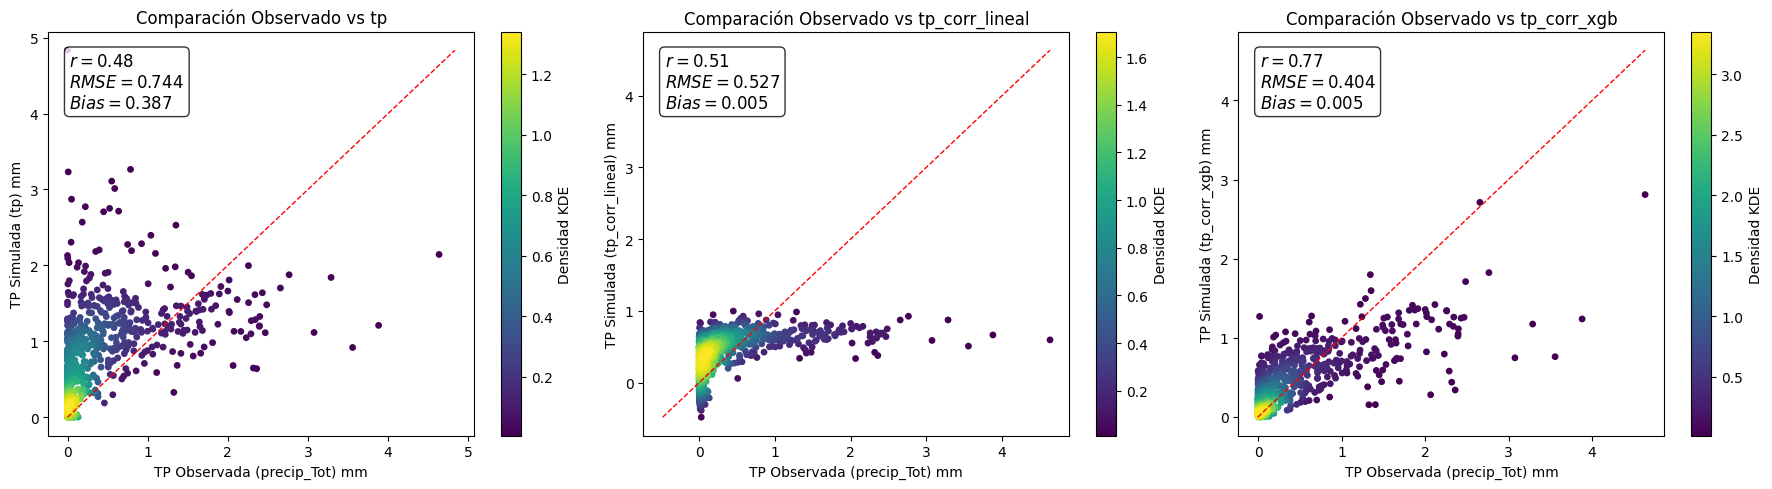

In [146]:
# Lista de variables simuladas para comparar con observados
sim_vars = ['tp', 'tp_corr_lineal', 'tp_corr_xgb']

plt.figure(figsize=(18, 5))

for i, var in enumerate(sim_vars, 1):
    # Preparar DataFrame con las columnas observadas y simuladas para la función plot_series y get_metrics
    df_plot = df_tp[['precip_Tot', var]].copy()
    
    # Obtener datos para graficar con densidad KDE
    y_obs, y_sim, dens = plot_series(df_plot)
    
    # Calcular métricas (r, bias, RMSE)
    metrics_text = get_metrics(df_plot)
    
    # Crear subplot
    ax = plt.subplot(1, 3, i)
    
    # Graficar scatter con color según densidad
    sc = ax.scatter(y_obs, y_sim, c=dens, s=15, cmap='viridis')
    
    # Línea 1:1 para referencia
    min_val = min(y_obs.min(), y_sim.min())
    max_val = max(y_obs.max(), y_sim.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    # Etiquetas y título
    ax.set_xlabel('TP Observada (precip_Tot) mm')
    ax.set_ylabel(f'TP Simulada ({var}) mm')
    ax.set_title(f'Comparación Observado vs {var}')
    
    # Añadir texto con métricas en la esquina superior izquierda
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Colorbar para la densidad
    plt.colorbar(sc, ax=ax, label='Densidad KDE')

plt.tight_layout()
plt.show()


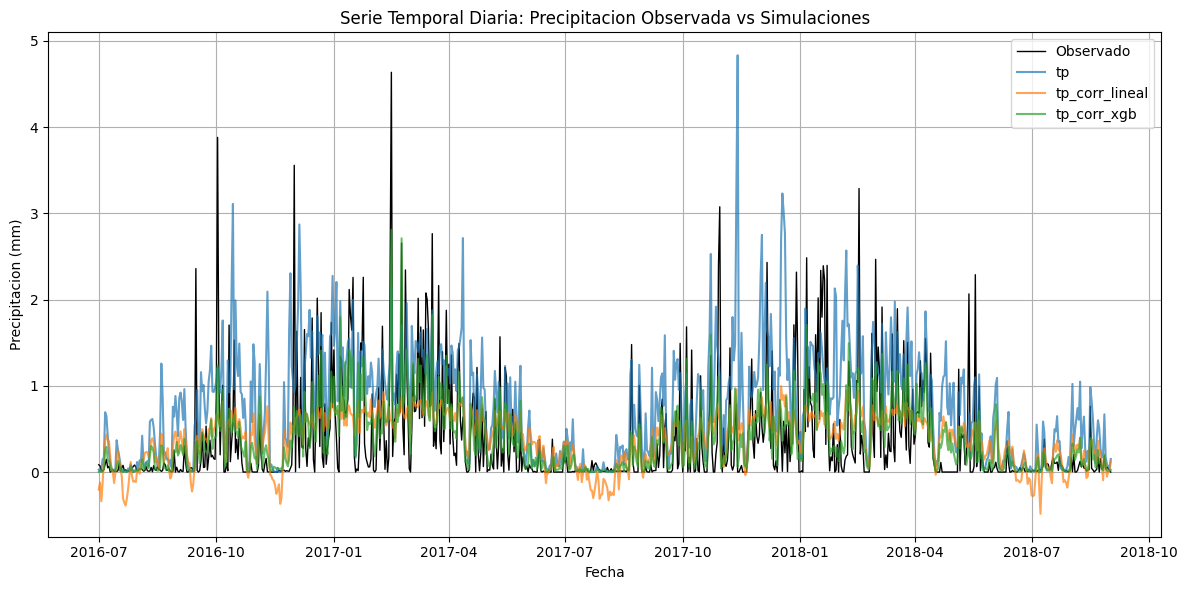

In [148]:
# Lista de variables simuladas
sim_vars = ['tp', 'tp_corr_lineal', 'tp_corr_xgb']

# Asegurarse de que el índice es datetime
df_ws2.index = pd.to_datetime(df_ws2.index)

# Agrupar por día y calcular la media
df_daily = df_tp[['precip_Tot'] + sim_vars].resample('D').mean().dropna()

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar observaciones
plt.plot(df_daily.index, df_daily['precip_Tot'], label='Observado', color='black', linewidth=1)

# Graficar simulaciones
for var in sim_vars:
    plt.plot(df_daily.index, df_daily[var], label=var, alpha=0.7)

# Personalizar gráfico
plt.title('Serie Temporal Diaria: Precipitacion Observada vs Simulaciones')
plt.xlabel('Fecha')
plt.ylabel('Precipitacion (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
